<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## MSDS453 - Research Assignment 02 - Classification and Clustering

Clustering methods compute a similarity (or closeness) measure, such as Euclidean distance, in order to decide whether two documents are ‘similar’ or not.  

Use the entire class corpus and do sentiment analysis for the positive and negative reviews.

Topic modeling is another way to group ‘similar’ documents into ‘clusters’. 

In [1]:

import pandas as pd
import os
import numpy as np
import scipy as sp
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
from gensim import corpora, similarities
from gensim.models import Word2Vec, LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LsiModel,LdaModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from sklearn.metrics import silhouette_score

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict
#
import pandas as pd
import os
import random
import numpy as np
import pickle 
import re,string

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, silhouette_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_predict


import seaborn as sns
import matplotlib.pyplot as plt

import gensim
from gensim import corpora, similarities
from gensim.models import Word2Vec, LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LsiModel,LdaModel

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, GRU
from keras.callbacks import EarlyStopping
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
#from keras.optimizers import Adam, Nadam, RMSprop
from keras import Input

from IPython.display import display

### Mount Google Drive to Colab Environment

<div class="alert alert-block alert-success">
    <b>Directories Required for Research Assignment</b>:<br> 
1. Data Directory - Source Class Corpus Data<br>
2. Output Directory - Vocabulary<br>
</div>

#### Uncomment To Map Drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### NLTK Downloads

In [4]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [5]:
import pkg_resources
pkg_resources.require("gensim<=3.8.3");

In [6]:
print("Genism Version: ", gensim.__version__)

Genism Version:  3.6.0


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [7]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [8]:
from pandas.core.ops.array_ops import Any
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path, encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

@dataclass
class Document:
    doc_id: str
    text: str

def normalize_document(document: Document) -> Document:
    text = document.text
    text = remove_punctuation(text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)
    
    return Document(document.doc_id, text)

def normalize_documents(documents: List[Document]) -> List[Document]:
    """
    Normalizes text for all given documents.
    Removes punctuation, converts to lower case, removes tags and special characters.
    """
    return [normalize_document(x) for x in documents]

@dataclass
class TokenizedDocument:
    doc_id: str
    tokens: List[str]

def tokenize_document(document: Document) -> TokenizedDocument:
    tokens = nltk.word_tokenize(document.text)
    return TokenizedDocument(document.doc_id, tokens)

def tokenize_documents(documents: List[Document]) -> List[TokenizedDocument]:
    return [tokenize_document(x) for x in documents]

def lemmatize(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    lemmatizer = WordNetLemmatizer()
    for document in documents:
        output_tokens = [lemmatizer.lemmatize(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))
        
    return result

def stem(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    stemmer = PorterStemmer()
    for document in documents:
        output_tokens = [stemmer.stem(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))

    return result

def remove_stop_words(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    
    stop_words = set(nltk.corpus.stopwords.words('english')) 
    for document in documents:
        filtered_tokens = [w for w in document.tokens if not w in stop_words]
        result.append(TokenizedDocument(document.doc_id, filtered_tokens))
        
    return result
    
def add_flags(data: pd.DataFrame, angel_has_fallen_doc_ids: List[int], action_doc_ids: List[int]):
    data['is_angel_has_fallen'] = data.index.isin(angel_has_fallen_doc_ids)
    data['is_action'] = data.index.isin(action_doc_ids)
    
def get_all_tokens(documents: List[TokenizedDocument]) -> List[str]:
    tokens = {y for x in documents for y in x.tokens}
    return sorted(list(tokens))

def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

def final_processed_text(doc):
    #this is a function to join the processed text back
    ' '.join(doc)
    return doc

def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix
    words = Tfidf.get_feature_names()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)
    return matrix #,words

def One_Hot(variable):
    #this is a function to one hot encode the classes
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels

## Functions Latent Semantic Analysis, Latent Dirichlet Allocation, Word2Vec Matrix 
1. Latent Semantic Analysis 
2. Latent Dirichlet Allocation
3. Word2Vec Matrix creation

In [25]:
from multiprocessing import Value

def create_gensim_lsa_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    # train model
    lsamodel = LsiModel(doc_term_matrix
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,power_iters=100)
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    return lsamodel,dictionary,index

def lsa(tfidf_matrix, terms, n_components = 10):
    #this is a function to execute lsa.  inputs to the function include the tfidf matrix and
    #the desired number of components.
    
    LSA = TruncatedSVD(n_components=10)
    LSA.fit(tfidf_matrix)

    for i, comp in enumerate(LSA.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("Topic "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])


            
def create_gensim_lda_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    ldamodel = LdaModel(doc_term_matrix
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,alpha='auto'
                        ,eta='auto'
                        ,iterations=1000
                        ,random_state=23
                        ,passes=200)
    # train model
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])
    return ldamodel,dictionary,index,doc_term_matrix

def lda(tfidf_matrix, terms, topics = 3, num_words = 10):
    #this is a function to perform lda on the tfidf matrix.  function varibales include:
    #tfidf matrix, desired number of topic, and number of words per topic.

    topics = 3
    num_words = 10
    lda = LatentDirichletAllocation(n_components=topics).fit(tfidf_matrix)

    topic_dict = {}
    for topic_num, topic in enumerate(lda.components_):
        topic_dict[topic_num] = " ".join([terms[i]for i in topic.argsort()[:-num_words - 1:-1]])

    print(topic_dict)
    
def word2vec(processed_text, size = 100):
    #This is a function to generate the word2vec matrix. Input parameters include the 
    #tokenized text and matrix size
    
    #word to vec
    model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

    #join all processed DSI words into single list
    processed_text_w2v=[]
    for i in processed_text:
        for k in i:
            processed_text_w2v.append(k)

    #obtian all the unique words from DSI
    w2v_words=list(set(processed_text_w2v))

    #can also use the get_feature_names() from TFIDF to get the list of words
    #w2v_words=Tfidf.get_feature_names()

    #empty dictionary to store words with vectors
    w2v_vectors={}

    #for loop to obtain weights for each word
    for i in w2v_words:
        temp_vec=model_w2v.wv[i]
        w2v_vectors[i]=temp_vec

    #create a final dataframe to view word vectors
    w2v_df=pd.DataFrame(w2v_vectors).transpose()
    print(w2v_df)
    return w2v_df

## Modeling Functions: KMeans, SVM, Logistic, Naive Bayes, Randomforest

In [10]:

def k_means(titles, tfidf_matrix, k=3):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    #Returns dataframe indicating cluster number per document

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.   
    for i in range(k):
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

    return cluster_title,clusters,frame

def classifiers(x, y, model_type, cv = 3):
    
    #this function is to fit 3 different model scenarios.  Support vector machines, logistic regressions, naive bayes.
    #svm = Support vector machin
    #logistic = Logistic regression
    #naive_bayes = Naive Bayes Multinomial
    
    #can define cv value for cross validation.
    
    #function returns the train test split scores of each model.
    
    if model_type == 'svm':
        print("svm")
        model = SVC()

    elif model_type == 'logistic':
        print("logistic")
        model = LogisticRegression()

    elif model_type == 'naive_bayes':
        print("naive_bayes")
        model = MultinomialNB()
    
    elif model_type == 'randomforest':
        print("randomforest")
        model = RandomForestClassifier()

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    accy = accuracy_score(y_test, predictions) 
    return accy
'''
def k_means(titles, tfidf_matrix, k=3):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    #Returns dataframe indicating cluster number per document

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

    print("Top terms per cluster:")
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    terms_dict=[]

    #dictionary to store clusters and respective titles
    cluster_terms={}
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.  

    for i in range(k):
        print("Cluster %d:" % i),
        temp_terms=[]
        temp_titles=[]
        temp=frame[frame['Cluster']==i]
        docs_list = temp['Doc Name'].tolist()
        cluster_matrix = tfidf_matrix.loc[docs_list]

        df1 = pd.DataFrame(columns = ['term', 'Average tf-idf score'])

        for ind in order_centroids[i, :10]:
            #print(' %s' % terms[ind])
            #print(round(cluster_matrix.iloc[:,ind].mean(),5))
            terms_dict.append(terms[ind])
            temp_terms.append(terms[ind])
                        
            df1 = df1.append({'term': terms[ind], 'Average tf-idf score':round(cluster_matrix.iloc[:,ind].mean(),4) }, ignore_index = True)
        cluster_terms[i]=temp_terms
        print(df1)
        print("\n")

        print("Cluster %d titles:" % i, end = '')
        temp=frame[frame['Cluster']==i]
        for title in temp['Doc Name']:
            print(' %s' % title, end='\n')
            temp_titles.append(title)
        cluster_title[i]=temp_titles
        print("\n")


    return cluster_title,clusters,frame
    '''

'\ndef k_means(titles, tfidf_matrix, k=3):\n    \n    #this is a function to generate the k-means output using the tfidf matrix.  Inputs \n    #to the function include: titles of text, processed text, and desired k value. \n    #Returns dataframe indicating cluster number per document\n\n    km = KMeans(n_clusters=k, random_state =89)\n    km.fit(tfidf_matrix)\n    clusters = km.labels_.tolist()\n\n    Dictionary={\'Doc Name\':titles, \'Cluster\':clusters,  \'Text\': final_processed_text}\n    frame=pd.DataFrame(Dictionary, columns=[\'Cluster\', \'Doc Name\',\'Text\'])\n\n    print("Top terms per cluster:")\n    #sort cluster centers by proximity to centroid\n    order_centroids = km.cluster_centers_.argsort()[:, ::-1] \n\n    terms_dict=[]\n\n    #dictionary to store clusters and respective titles\n    cluster_terms={}\n    cluster_title={}\n\n    #note doc2vec clusters will not have individual words due to the vector representation\n    #is based on the entire document not indvidual 

## Visualization Utility Functions

In [11]:
'''
def plot_lsa(number_of_topics, words):

    model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words)

    for doc in processed_text:
        vec_bow = dictionary.doc2bow(doc)
        vec_lsi = model[vec_bow]  # convert the query to LSI space
        sims = index[vec_lsi] # perform a similarity query against the corpus

    fig, ax = plt.subplots(figsize=(30, 10))
    cax = ax.matshow(index, interpolation='nearest')
    ax.grid(True)
    plt.xticks(range(len(processed_text)), titles, rotation=90);
    plt.yticks(range(len(processed_text)), titles);
    fig.colorbar(cax)
    plt.show()
    return model
    '''
def plot_lsa(number_of_topics, words):

    ######################################
    #Function to plot the LSA based on user defined number of topics and words
    #EXPERIMENT WITH THESE PARAMETERS topics and words

    #####################################
    model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words)

    for doc in processed_text:
        vec_bow = dictionary.doc2bow(doc)
        vec_lsi = model[vec_bow]  # convert the query to LSI space
        sims = index[vec_lsi] # perform a similarity query against the corpus

    fig, ax = plt.subplots(figsize=(35, 35))
    cax = ax.matshow(index, interpolation='nearest')
    ax.grid(True)
    plt.xticks(range(len(processed_text)), titles, rotation=90);
    plt.yticks(range(len(processed_text)), titles);
    fig.colorbar(cax)
    plt.show()
    return model

def plot_tfidf_matrix(cluster_title,clusters,TFIDF_matrix):
    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.

    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    dist = 1 - cosine_similarity(TFIDF_matrix)
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    xs, ys = pos[:, 0], pos[:, 1]


    #set up colors per clusters using a dict.  number of colors must correspond to K
    cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                      5:'red', 6:'darksalmon', 7:'sienna'}

    #set up cluster names using a dict.  
    cluster_dict=cluster_title

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

    #group by cluster
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(20,20)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label=cluster_dict[name], color=color, 
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='on')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='on')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30})      #show legend with only 1 point

## Loading the Class Corpus

In [12]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/djp840/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec56_v1_20220930.csv'
data = get_corpus_df(CORPUS_PATH)

In [13]:
#read in class corpus csv into python
#data=pd.read_csv(r'./data/MSDS453_Sec57_2202_ClassCorpus_v2.csv')

#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))

#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
titles = data['DSI_Title'].tolist()
processed_text = data['processed_text'].tolist()


1. Dataframe = corpus_df
2. List = documents (Document ID, Text)

## Exploritory Data Analysis

In [14]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/djp840/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec56_v1_20220930.csv'
corpus_df = get_corpus_df(CORPUS_PATH)
documents = [Document(x, y) for x, y in zip(corpus_df.Doc_ID, corpus_df.Text)]

In [15]:
corpus_df.shape

(200, 9)

In [16]:
corpus_df.head().T

Doc_ID                                                                   60  \
DSI_Title                                           KLD_Doc1_AngelHasFallen   
Text                      The sleepy, dopey action bonanza  Angel Has Fa...   
Submission File Name                                KLD_Doc1_AngelHasFallen   
Student Name                                                            KLD   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_60   
Doc_ID                                                                   60   

Doc_ID                                                                   61  \
DSI_Title                                           KLD_Doc2_AngelHasFallen   
Text                       Angel Has Fallen  marks the third time that G...   
Submission File Name                                KLD_Doc2_AngelHasFallen   
Student Name                                                            KLD   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_61   
Doc_ID                                                                   61   

Doc_ID                                                                   62  \
DSI_Title                                           KLD_Doc3_AngelHasFallen   
Text                      In 2013 audiences were first introduced to Sec...   
Submission File Name                                KLD_Doc3_AngelHasFallen   
Student Name                                                            KLD   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_62   
Doc_ID                                                                   62   

Doc_ID                                                                   63  \
DSI_Title                                           KLD_Doc4_AngelHasFallen   
Text                      Ever heard of the phrase  a glutton for punish...   
Submission File Name                                KLD_Doc4_AngelHasFallen   
Student Name                                                            KLD   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_63   
Doc_ID                                                                   63   

Doc_ID                                                                   64  
DSI_Title                                           KLD_Doc5_AngelHasFallen  
Text                      And here is part three of the  Fallen  trilogy...  
Submission File Name                                KLD_Doc5_AngelHasFallen  
Student Name                                                            KLD  
Genre of Movie                                                       Action  
Review Type (pos or neg)                                           Negative  
Movie Title                                                Angel Has Fallen  
Descriptor                                     Action_Angel Has Fallen_N_64  
Doc_ID                                                                   64

In [17]:
print(corpus_df.info());

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 60 to 119
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Text                      200 non-null    object
 2   Submission File Name      200 non-null    object
 3   Student Name              200 non-null    object
 4   Genre of Movie            200 non-null    object
 5   Review Type (pos or neg)  200 non-null    object
 6   Movie Title               200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 15.6+ KB
None


In [18]:
print(corpus_df['Movie Title'].unique())

['Angel Has Fallen' 'Inception' 'No time to die' 'Taken' 'The Revenant'
 'The Toxic Avenger' 'DespicableMe3' 'Dirty Grandpa' 'Happy Gilmore'
 'Legally Blonde' 'The Lost City' 'Drag me to hell' 'Fresh'
 'It Chapter Two' 'Us' 'Equilibrium' 'Minority Report' 'Oblivion'
 'Pitch Black' 'The Batman']


In [ ]:
def lsa(tfidf_matrix, terms, n_components = 10):
    #this is a function to execute lsa.  inputs to the function include the tfidf matrix and
    #the desired number of components.
    
    LSA = TruncatedSVD(n_components=10)

    LSA.fit(tfidf_matrix)


    for i, comp in enumerate(LSA.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
        print("Topic "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])

## Latent Semantic Analysis - Research Number of Topics and Number of Words

https://www.datacamp.com/tutorial/discovering-hidden-topics-python

### Plotting 2 concepts and 10 words

[(0, '0.377*"movie" + 0.283*"batman" + 0.136*"character" + 0.131*"anderton" + 0.130*"would" + 0.129*"story" + 0.124*"characters" + 0.116*"first" + 0.116*"action" + 0.110*"spielberg"'), (1, '-0.454*"batman" + 0.411*"anderton" + 0.279*"spielberg" + 0.257*"minority" + 0.256*"report" + 0.173*"precrime" + 0.146*"future" + 0.135*"technology" + -0.127*"reeves" + -0.101*"movie"')]


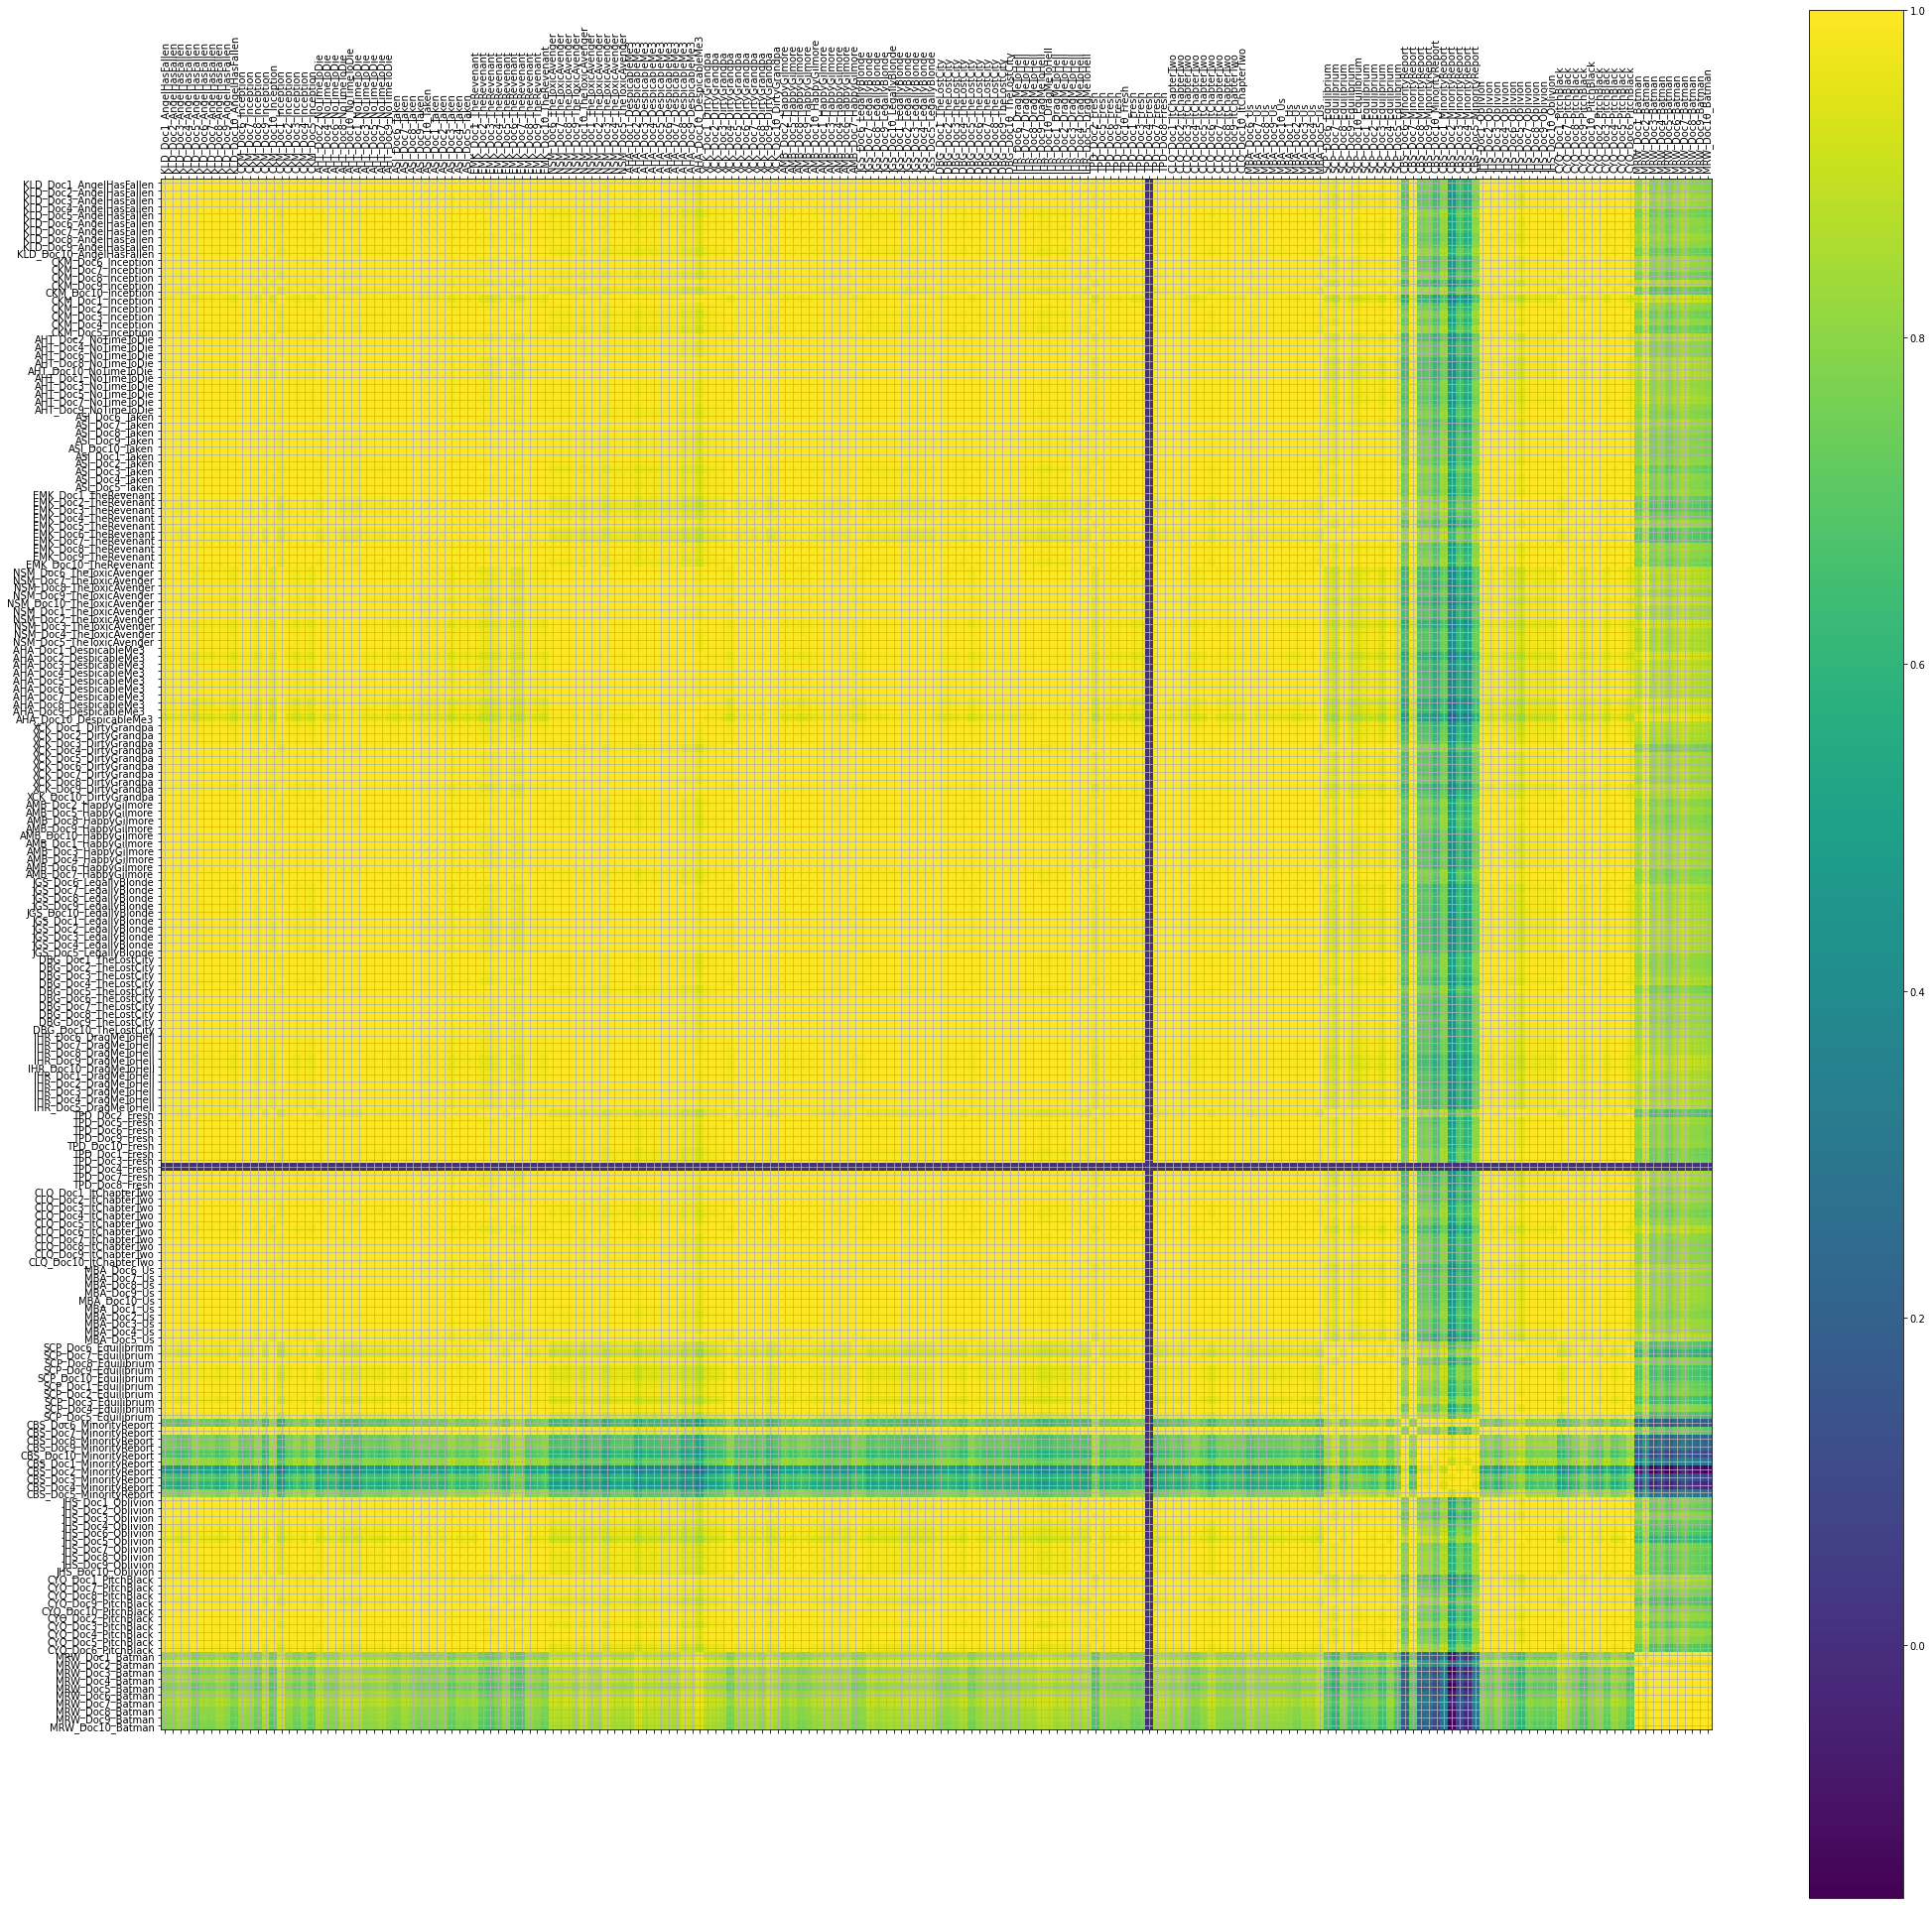

In [19]:
model_2concepts_10words=plot_lsa(2, 10)

Plotting 4 concepts and 10 words

[(0, '0.377*"movie" + 0.283*"batman" + 0.136*"character" + 0.131*"anderton" + 0.130*"would" + 0.129*"story" + 0.124*"characters" + 0.116*"first" + 0.116*"action" + 0.110*"spielberg"'), (1, '-0.454*"batman" + 0.411*"anderton" + 0.279*"spielberg" + 0.257*"minority" + 0.256*"report" + 0.173*"precrime" + 0.146*"future" + 0.135*"technology" + -0.127*"reeves" + -0.101*"movie"'), (2, '0.546*"batman" + -0.263*"movie" + -0.241*"toxic" + 0.229*"anderton" + 0.154*"reeves" + -0.144*"avenger" + 0.137*"spielberg" + 0.126*"report" + 0.125*"minority" + -0.123*"action"'), (3, '-0.513*"toxic" + -0.325*"avenger" + -0.248*"troma" + -0.242*"melvin" + 0.198*"action" + 0.152*"banning" + -0.140*"toxie" + -0.102*"batman" + 0.099*"fallen" + -0.097*"anderton"')]


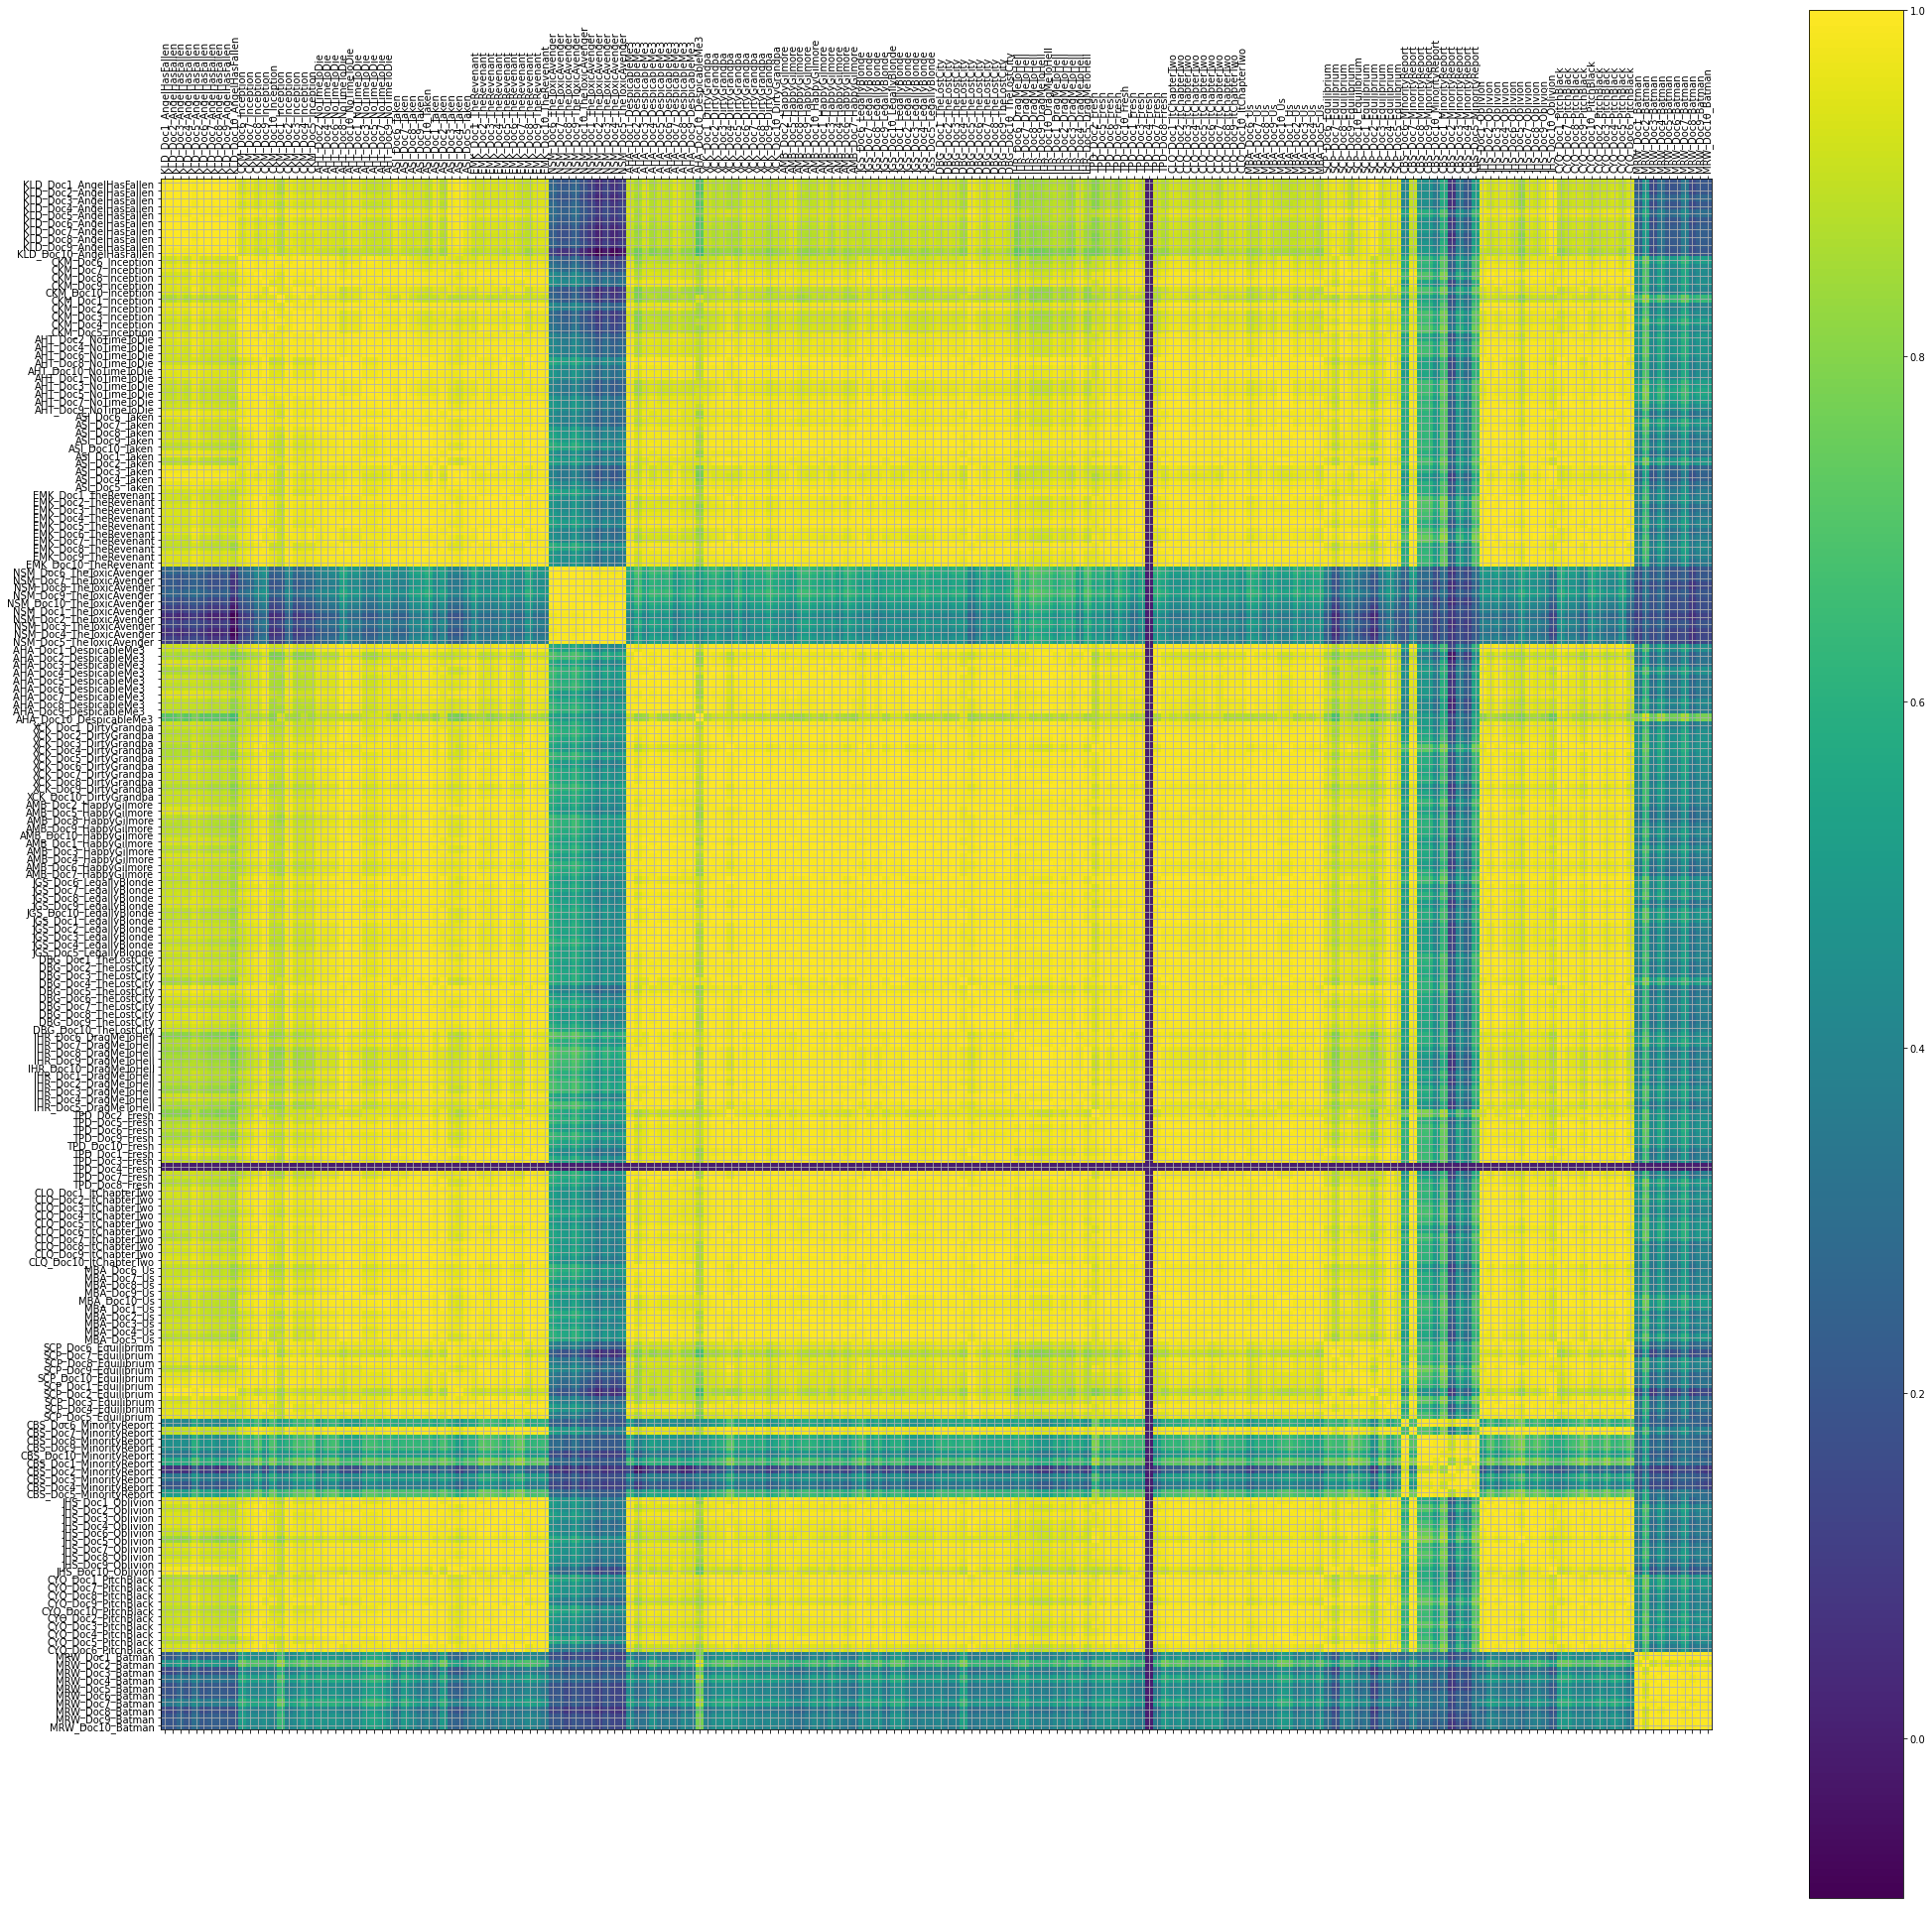

In [20]:
model_4concepts_10words=plot_lsa(4, 10)

### Plotting 6 concepts and 10 words

[(0, '0.377*"movie" + 0.283*"batman" + 0.136*"character" + 0.131*"anderton" + 0.130*"would" + 0.129*"story" + 0.124*"characters" + 0.116*"first" + 0.116*"action" + 0.110*"spielberg"'), (1, '-0.454*"batman" + 0.411*"anderton" + 0.279*"spielberg" + 0.257*"minority" + 0.256*"report" + 0.173*"precrime" + 0.146*"future" + 0.135*"technology" + -0.127*"reeves" + -0.101*"movie"'), (2, '-0.546*"batman" + 0.263*"movie" + 0.241*"toxic" + -0.229*"anderton" + -0.154*"reeves" + 0.144*"avenger" + -0.137*"spielberg" + -0.126*"report" + -0.125*"minority" + 0.123*"action"'), (3, '-0.513*"toxic" + -0.325*"avenger" + -0.248*"troma" + -0.242*"melvin" + 0.198*"action" + 0.152*"banning" + -0.140*"toxie" + -0.102*"batman" + 0.099*"fallen" + -0.097*"anderton"'), (4, '-0.264*"movie" + 0.228*"banning" + -0.213*"equilibrium" + 0.171*"inception" + 0.151*"nolan" + 0.146*"fallen" + -0.139*"future" + -0.123*"wimmer" + -0.108*"action" + 0.102*"angel"'), (5, '0.456*"banning" + 0.297*"fallen" + -0.271*"inception" + -0.2

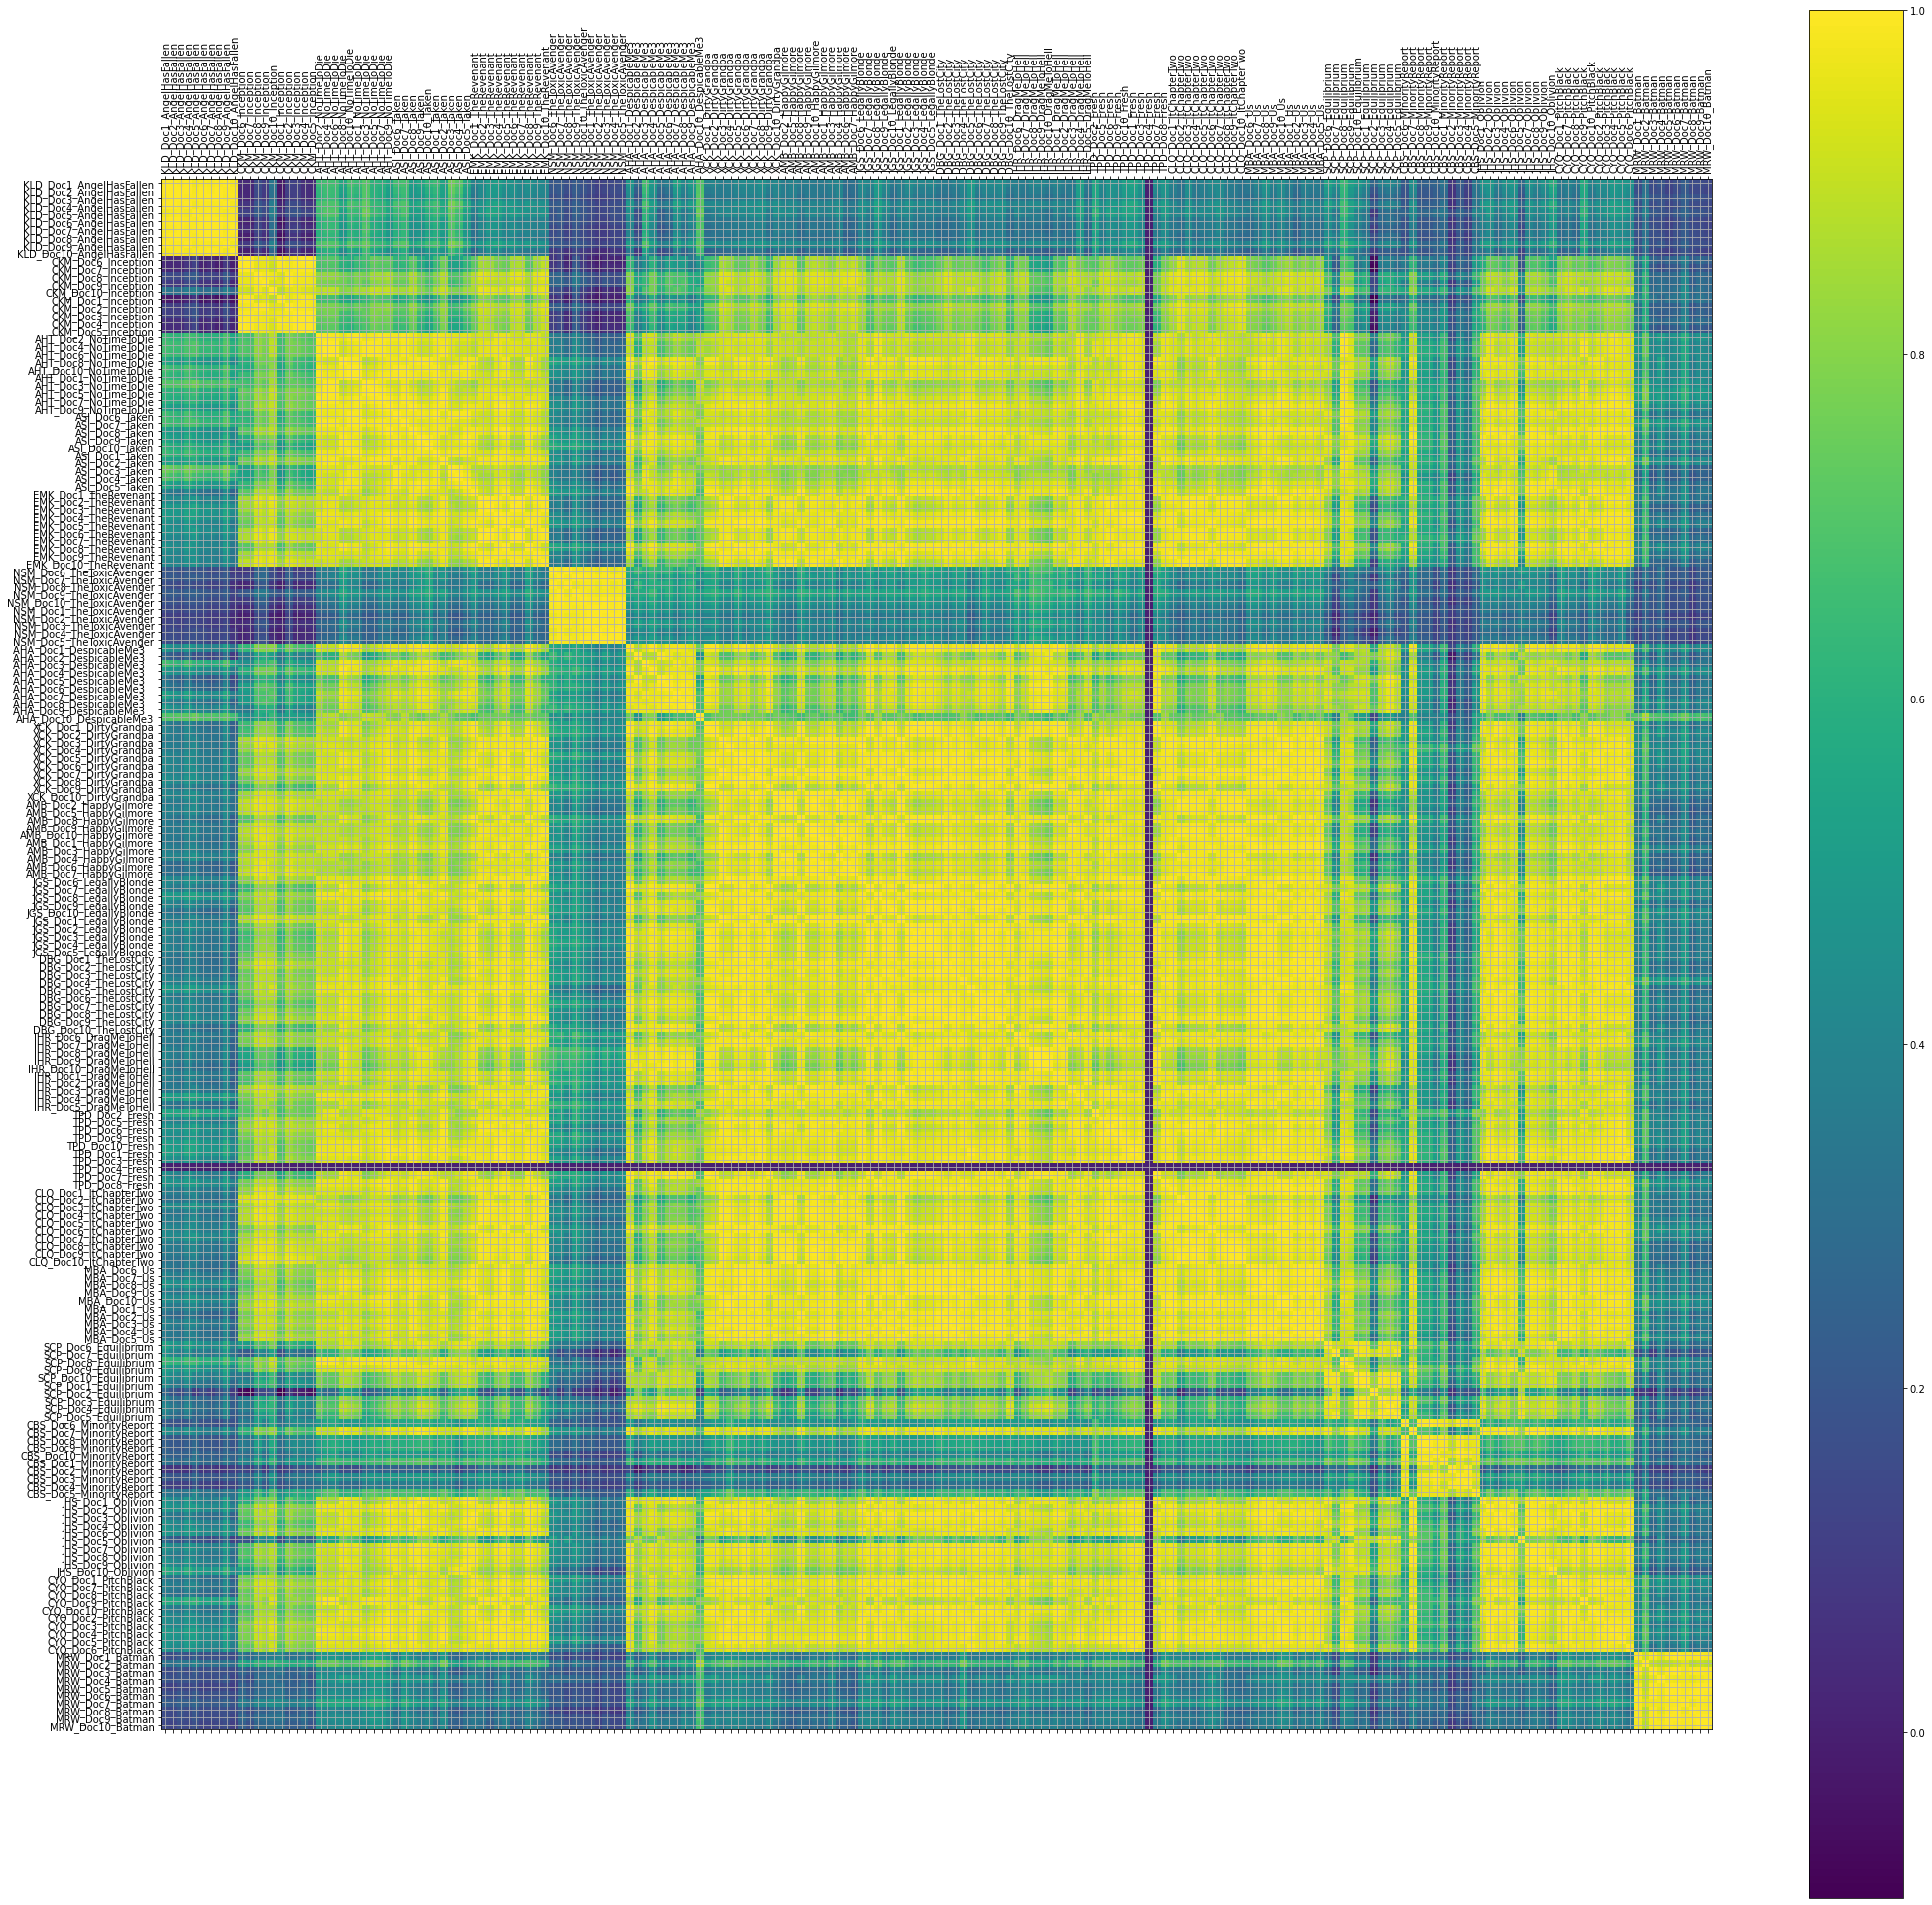

In [21]:
model_6concepts_10words=plot_lsa(6, 10)

### Plotting 20 concepts and 10 words

[(0, '-0.377*"movie" + -0.283*"batman" + -0.136*"character" + -0.131*"anderton" + -0.130*"would" + -0.129*"story" + -0.124*"characters" + -0.116*"first" + -0.116*"action" + -0.110*"spielberg"'), (1, '0.454*"batman" + -0.411*"anderton" + -0.279*"spielberg" + -0.257*"minority" + -0.256*"report" + -0.173*"precrime" + -0.146*"future" + -0.135*"technology" + 0.127*"reeves" + 0.101*"movie"'), (2, '0.546*"batman" + -0.263*"movie" + -0.241*"toxic" + 0.229*"anderton" + 0.154*"reeves" + -0.144*"avenger" + 0.137*"spielberg" + 0.126*"report" + 0.125*"minority" + -0.123*"action"'), (3, '0.513*"toxic" + 0.325*"avenger" + 0.248*"troma" + 0.242*"melvin" + -0.198*"action" + -0.152*"banning" + 0.140*"toxie" + 0.102*"batman" + -0.099*"fallen" + 0.097*"anderton"'), (4, '-0.264*"movie" + 0.228*"banning" + -0.213*"equilibrium" + 0.171*"inception" + 0.151*"nolan" + 0.146*"fallen" + -0.139*"future" + -0.123*"wimmer" + -0.108*"action" + 0.102*"angel"'), (5, '0.456*"banning" + 0.297*"fallen" + -0.271*"inception

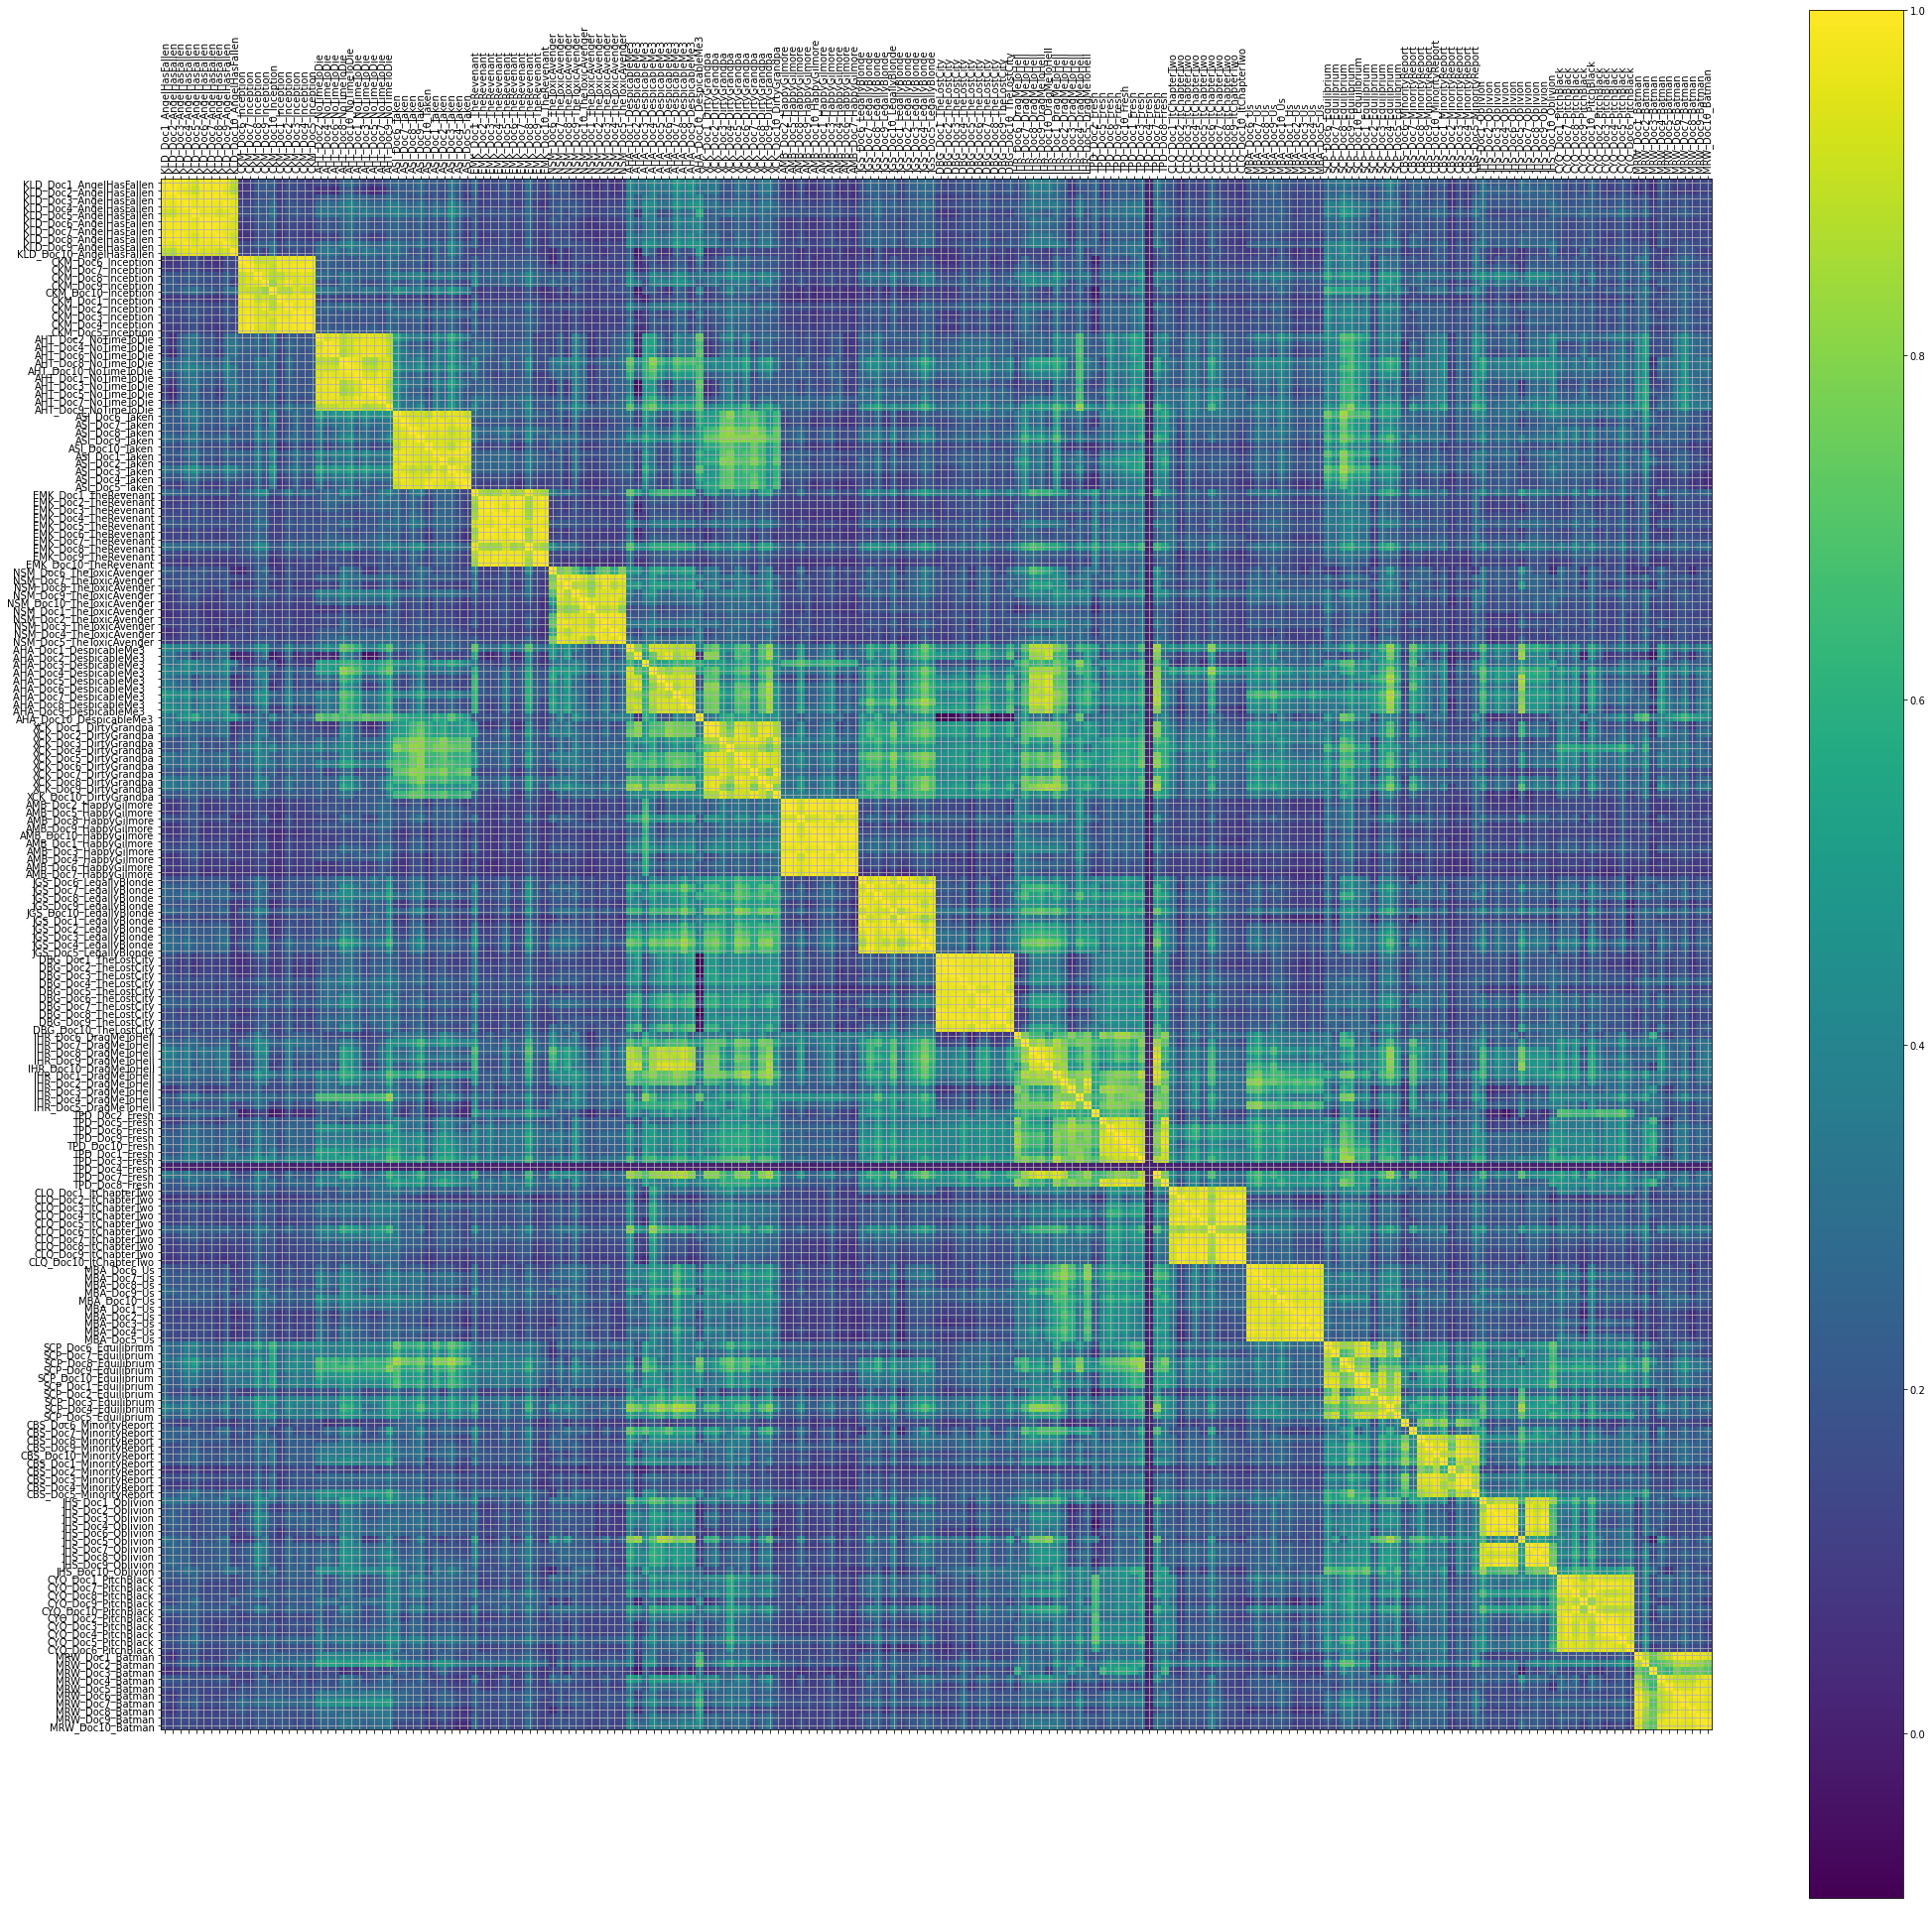

In [22]:
model_20concepts_10words=plot_lsa(20, 10)

### Compare LSA Model Coherence

In [23]:
topics = [2, 4, 6, 20]
coherence_values = []
for t in topics:
    lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10)


    coherence_model_lsa = CoherenceModel(model=lsamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lsa = coherence_model_lsa.get_coherence()
    coherence_values.append(coherence_lsa)

    
coherence ={'2 concepts 10 words':coherence_values[0],
           '4 concepts 10 words': coherence_values[1],
           '6 concepts 10 words':coherence_values[2],
           '20 concepts 10 words':coherence_values[3]}   

print(coherence)

[(0, '0.377*"movie" + 0.283*"batman" + 0.136*"character" + 0.131*"anderton" + 0.130*"would" + 0.129*"story" + 0.124*"characters" + 0.116*"first" + 0.116*"action" + 0.110*"spielberg"'), (1, '-0.454*"batman" + 0.411*"anderton" + 0.279*"spielberg" + 0.257*"minority" + 0.256*"report" + 0.173*"precrime" + 0.146*"future" + 0.135*"technology" + -0.127*"reeves" + -0.101*"movie"')]


[(0, '0.377*"movie" + 0.283*"batman" + 0.136*"character" + 0.131*"anderton" + 0.130*"would" + 0.129*"story" + 0.124*"characters" + 0.116*"first" + 0.116*"action" + 0.110*"spielberg"'), (1, '0.454*"batman" + -0.411*"anderton" + -0.279*"spielberg" + -0.257*"minority" + -0.256*"report" + -0.173*"precrime" + -0.146*"future" + -0.135*"technology" + 0.127*"reeves" + 0.101*"movie"'), (2, '-0.546*"batman" + 0.263*"movie" + 0.241*"toxic" + -0.229*"anderton" + -0.154*"reeves" + 0.144*"avenger" + -0.137*"spielberg" + -0.126*"report" + -0.125*"minority" + 0.123*"action"'), (3, '-0.513*"toxic" + -0.325*"avenger" + -0.248*"troma" + -0.242*"melvin" + 0.198*"action" + 0.152*"banning" + -0.140*"toxie" + -0.102*"batman" + 0.099*"fallen" + -0.097*"anderton"')]


[(0, '0.377*"movie" + 0.283*"batman" + 0.136*"character" + 0.131*"anderton" + 0.130*"would" + 0.129*"story" + 0.124*"characters" + 0.116*"first" + 0.116*"action" + 0.110*"spielberg"'), (1, '-0.454*"batman" + 0.411*"anderton" + 0.279*"spielberg" + 0.257*"minority" + 0.256*"report" + 0.173*"precrime" + 0.146*"future" + 0.135*"technology" + -0.127*"reeves" + -0.101*"movie"'), (2, '-0.546*"batman" + 0.263*"movie" + 0.241*"toxic" + -0.229*"anderton" + -0.154*"reeves" + 0.144*"avenger" + -0.137*"spielberg" + -0.126*"report" + -0.125*"minority" + 0.123*"action"'), (3, '0.513*"toxic" + 0.325*"avenger" + 0.248*"troma" + 0.242*"melvin" + -0.198*"action" + -0.152*"banning" + 0.140*"toxie" + 0.102*"batman" + -0.099*"fallen" + 0.097*"anderton"'), (4, '0.264*"movie" + -0.228*"banning" + 0.213*"equilibrium" + -0.171*"inception" + -0.151*"nolan" + -0.146*"fallen" + 0.139*"future" + 0.123*"wimmer" + 0.108*"action" + -0.102*"angel"'), (5, '0.456*"banning" + 0.297*"fallen" + -0.271*"inception" + -0.248*"

[(0, '-0.377*"movie" + -0.283*"batman" + -0.136*"character" + -0.131*"anderton" + -0.130*"would" + -0.129*"story" + -0.124*"characters" + -0.116*"first" + -0.116*"action" + -0.110*"spielberg"'), (1, '0.454*"batman" + -0.411*"anderton" + -0.279*"spielberg" + -0.257*"minority" + -0.256*"report" + -0.173*"precrime" + -0.146*"future" + -0.135*"technology" + 0.127*"reeves" + 0.101*"movie"'), (2, '-0.546*"batman" + 0.263*"movie" + 0.241*"toxic" + -0.229*"anderton" + -0.154*"reeves" + 0.144*"avenger" + -0.137*"spielberg" + -0.126*"report" + -0.125*"minority" + 0.123*"action"'), (3, '0.513*"toxic" + 0.325*"avenger" + 0.248*"troma" + 0.242*"melvin" + -0.198*"action" + -0.152*"banning" + 0.140*"toxie" + 0.102*"batman" + -0.099*"fallen" + 0.097*"anderton"'), (4, '0.264*"movie" + -0.228*"banning" + 0.213*"equilibrium" + -0.171*"inception" + -0.151*"nolan" + -0.146*"fallen" + 0.139*"future" + 0.123*"wimmer" + 0.108*"action" + -0.102*"angel"'), (5, '-0.456*"banning" + -0.297*"fallen" + 0.271*"incept

## Latent Dirichlet Allocation - Research Number of Topics and Number of Words

In [26]:
######################################
#EXPERIMENT WITH THESE PARAMETERS
number_of_topics=2
words=10
#####################################

[(0, '0.008*"movie" + 0.003*"first" + 0.003*"batman" + 0.003*"character" + 0.003*"story" + 0.003*"action" + 0.003*"would" + 0.003*"characters" + 0.003*"films" + 0.002*"could"'), (1, '0.008*"movie" + 0.003*"action" + 0.003*"character" + 0.003*"story" + 0.003*"first" + 0.003*"would" + 0.003*"batman" + 0.003*"films" + 0.003*"characters" + 0.002*"could"')]


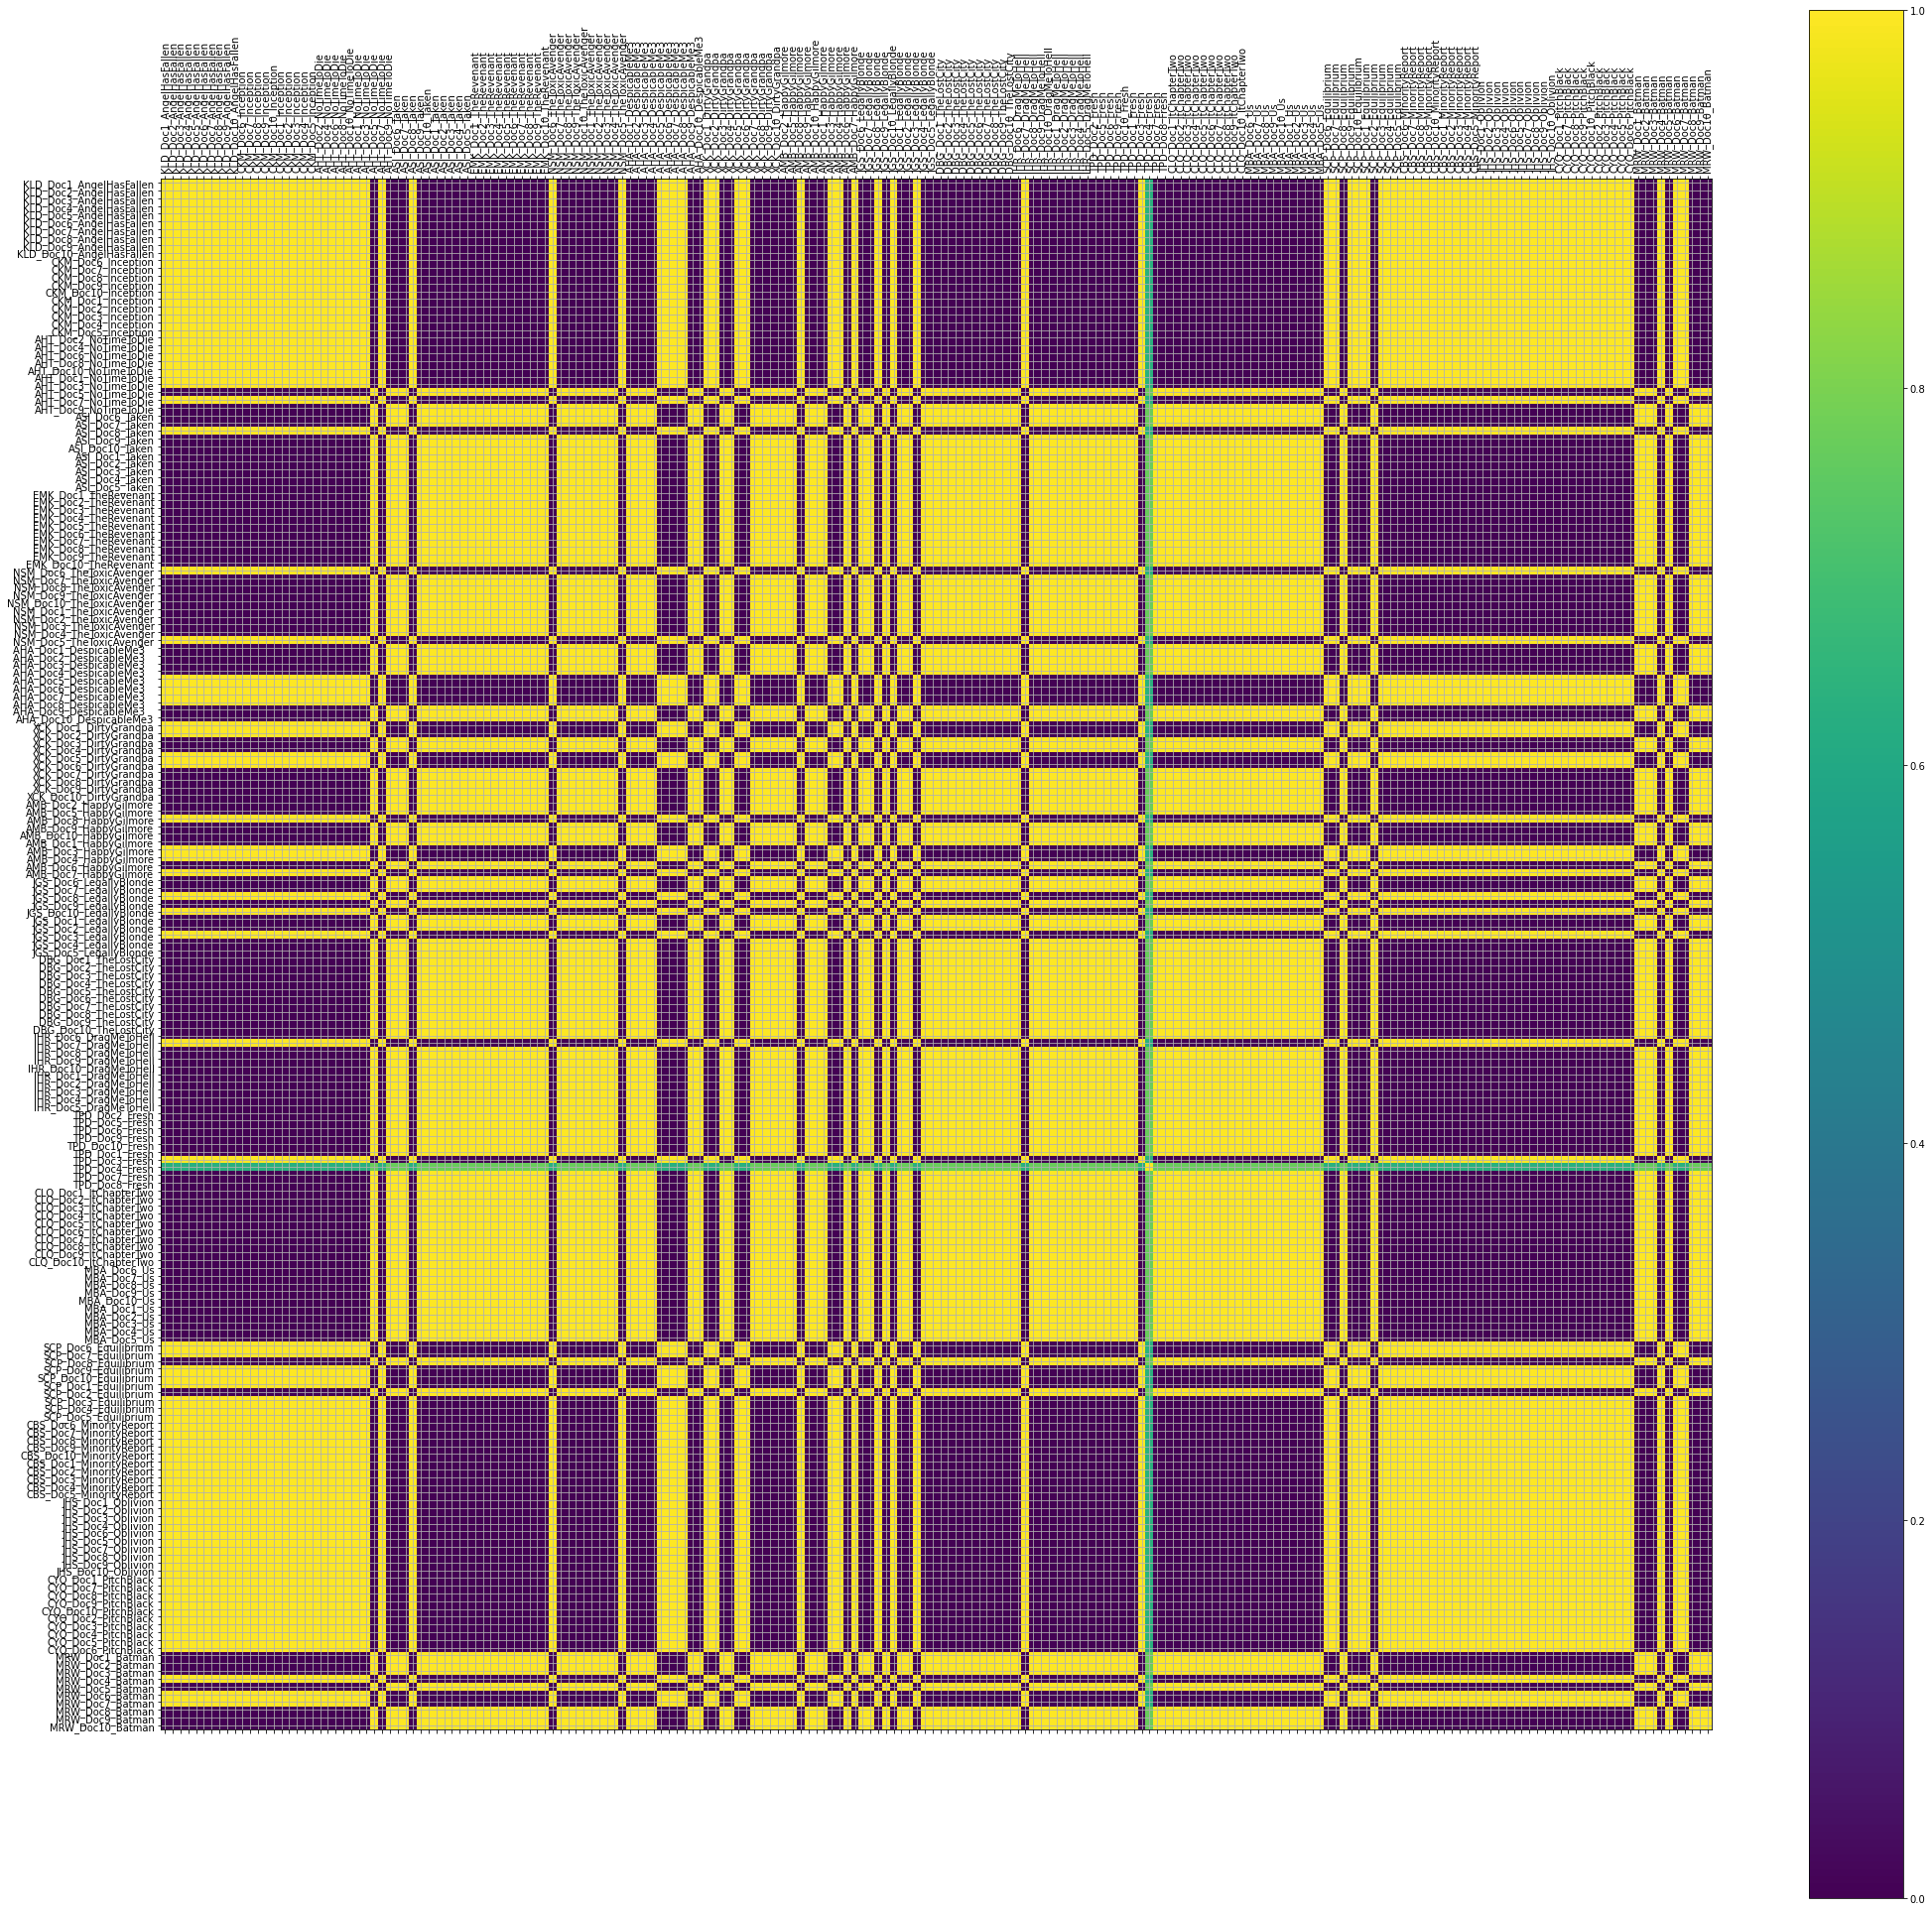

In [27]:
model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics,words)

for doc in processed_text:
    vec_bow2 = dictionary2.doc2bow(doc)
    vec2 = model2[vec_bow2]  # convert the query to embedded space
    sims2 = index2[vec2]  # perform a similarity query against the corpus
    #print(list(enumerate(sims2)))  

fig, ax = plt.subplots(figsize=(35, 35))
cax = ax.matshow(index2, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

In [28]:
######################################
#EXPERIMENT WITH THESE PARAMETERS
number_of_topics=4
words=10
#####################################

[(0, '0.008*"movie" + 0.003*"first" + 0.003*"action" + 0.003*"story" + 0.003*"character" + 0.003*"characters" + 0.003*"would" + 0.003*"films" + 0.003*"horror" + 0.002*"movies"'), (1, '0.008*"movie" + 0.003*"story" + 0.003*"would" + 0.003*"action" + 0.003*"character" + 0.003*"first" + 0.003*"films" + 0.003*"world" + 0.003*"characters" + 0.003*"people"'), (2, '0.009*"movie" + 0.003*"action" + 0.003*"character" + 0.003*"would" + 0.003*"first" + 0.003*"story" + 0.002*"films" + 0.002*"characters" + 0.002*"could" + 0.002*"movies"'), (3, '0.009*"movie" + 0.004*"batman" + 0.003*"character" + 0.003*"story" + 0.003*"first" + 0.003*"action" + 0.003*"characters" + 0.003*"would" + 0.003*"films" + 0.002*"could"')]


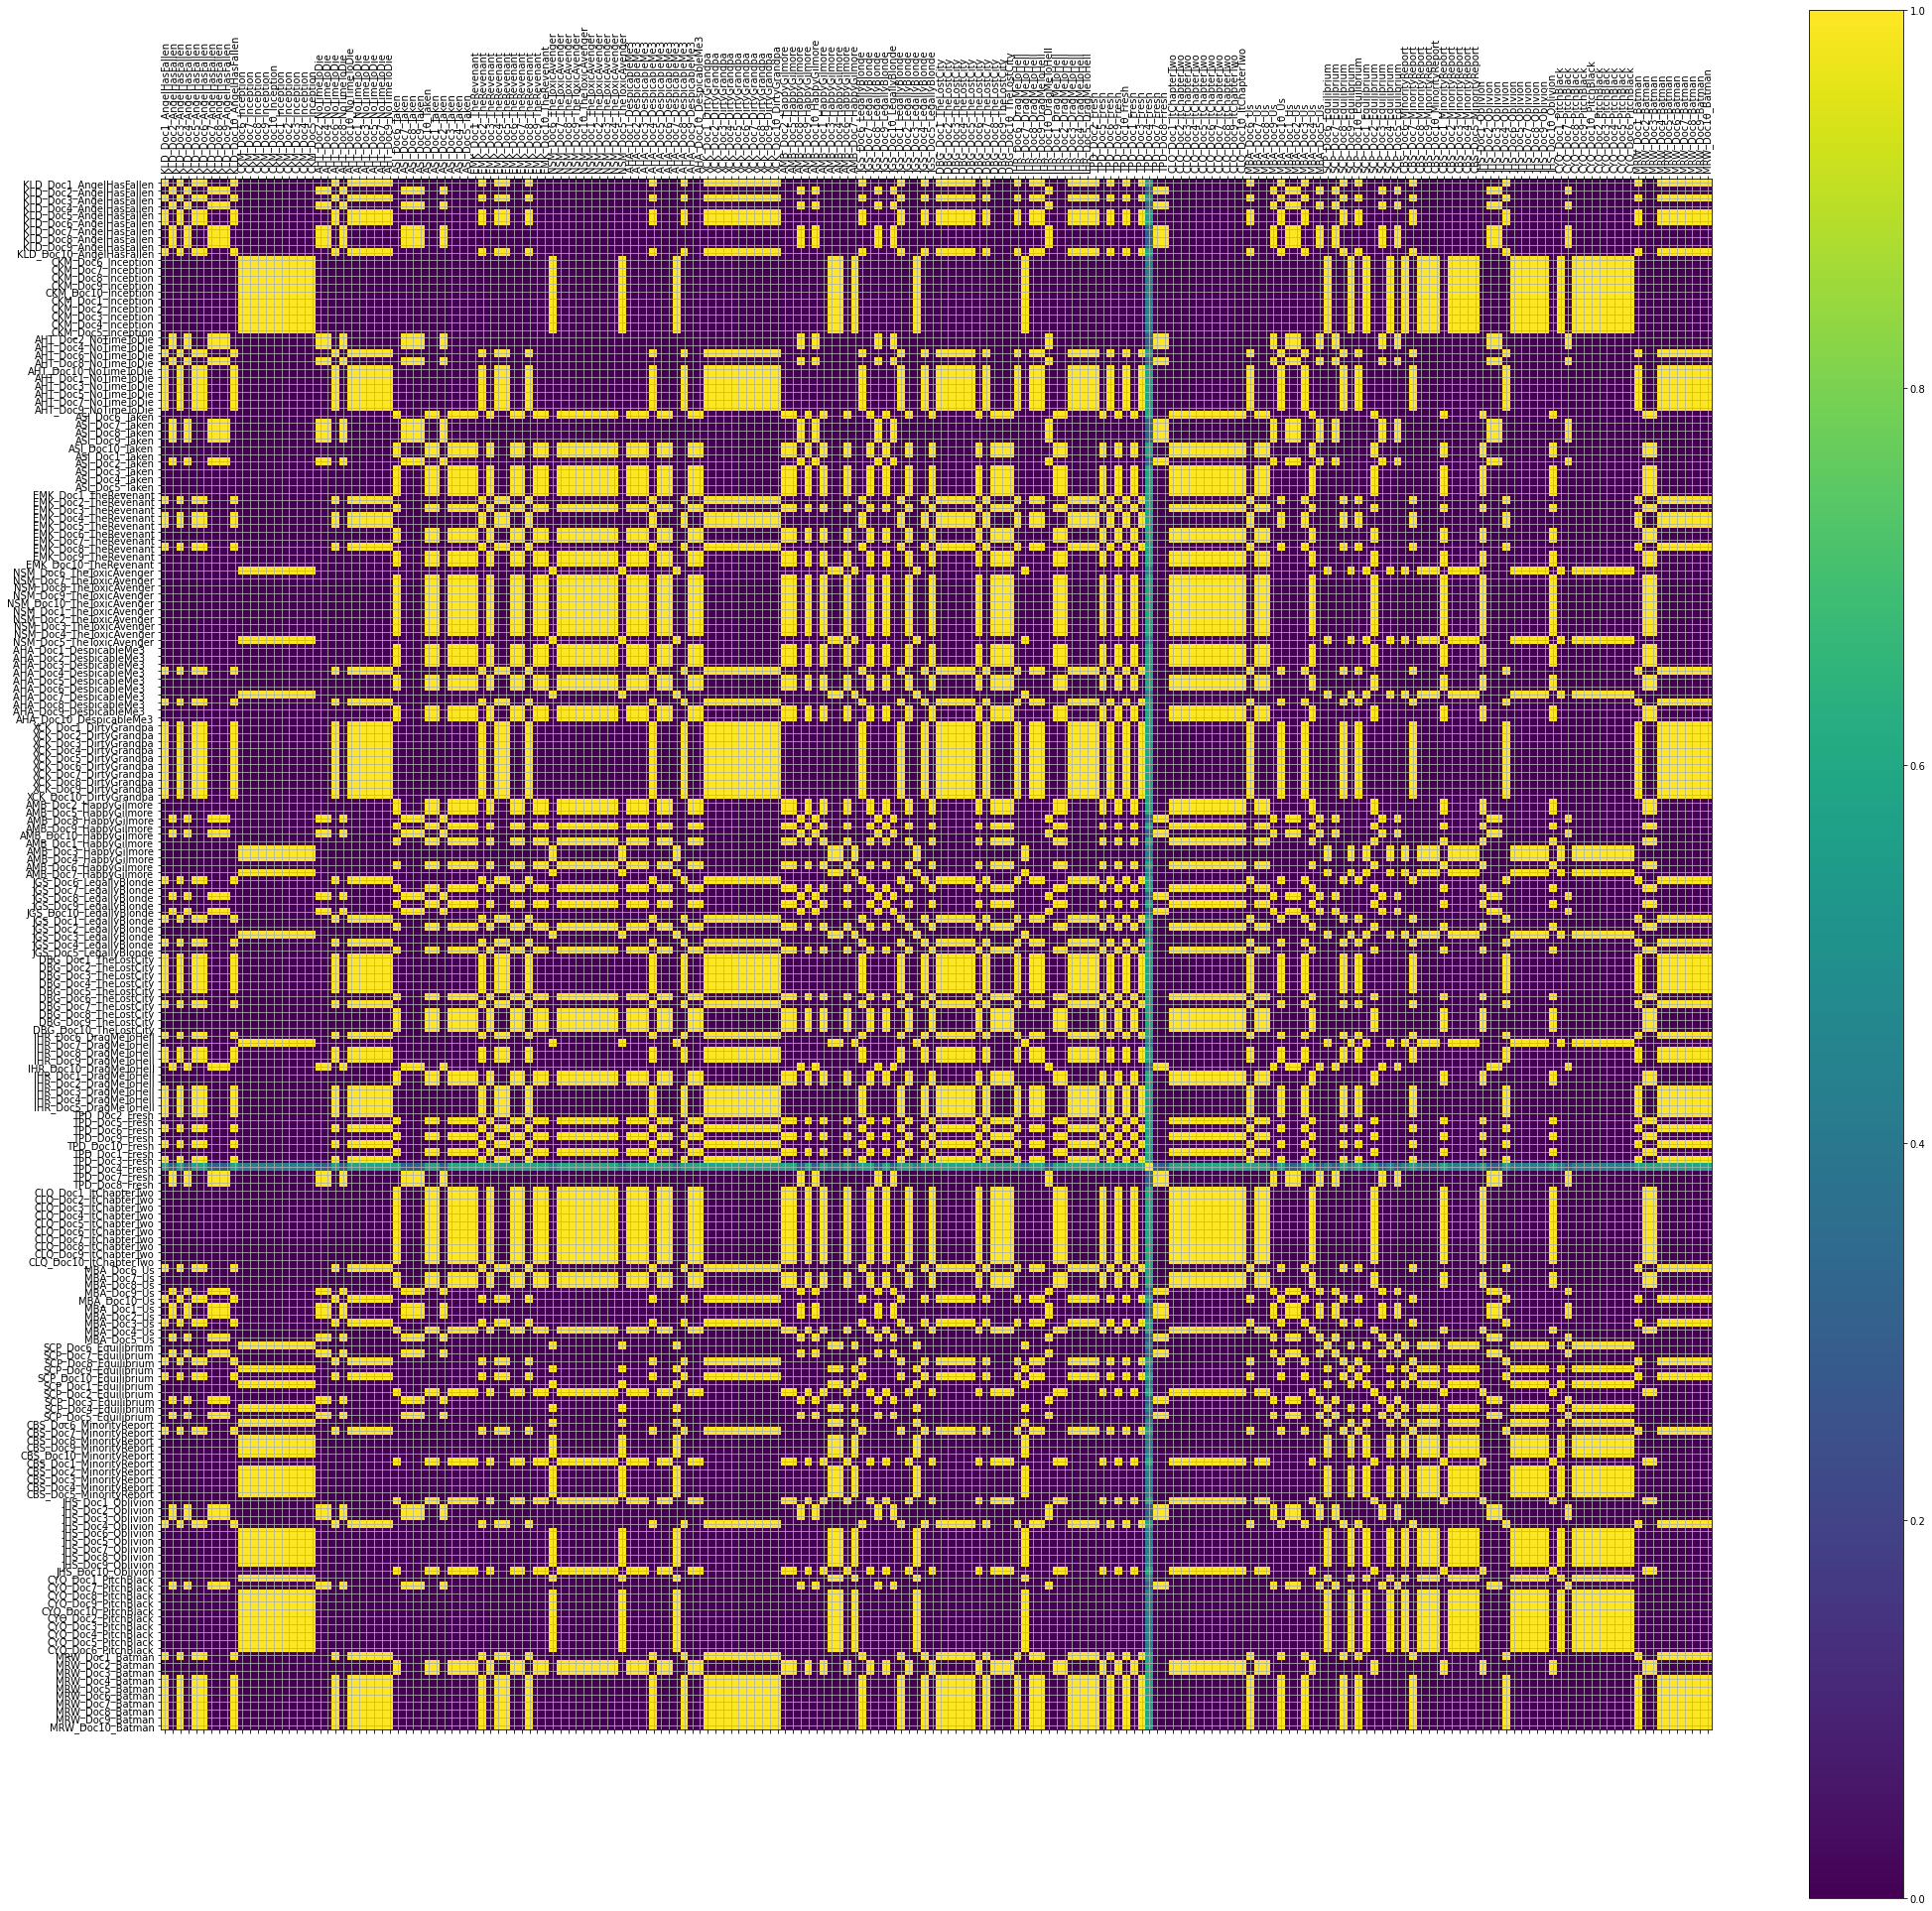

In [29]:
model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics,words)

for doc in processed_text:
    vec_bow2 = dictionary2.doc2bow(doc)
    vec2 = model2[vec_bow2]  # convert the query to embedded space
    sims2 = index2[vec2]  # perform a similarity query against the corpus
    #print(list(enumerate(sims2)))  

fig, ax = plt.subplots(figsize=(35, 35))
cax = ax.matshow(index2, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

In [30]:
######################################
#EXPERIMENT WITH THESE PARAMETERS
number_of_topics=6
words=10
#####################################

[(0, '0.008*"movie" + 0.004*"first" + 0.003*"story" + 0.003*"character" + 0.003*"action" + 0.003*"characters" + 0.002*"could" + 0.002*"films" + 0.002*"never" + 0.002*"would"'), (1, '0.007*"movie" + 0.003*"story" + 0.003*"action" + 0.003*"would" + 0.003*"character" + 0.003*"anderton" + 0.003*"first" + 0.003*"films" + 0.003*"world" + 0.003*"nolan"'), (2, '0.008*"movie" + 0.003*"character" + 0.003*"would" + 0.003*"action" + 0.003*"first" + 0.003*"story" + 0.003*"characters" + 0.002*"films" + 0.002*"could" + 0.002*"years"'), (3, '0.008*"movie" + 0.003*"character" + 0.003*"action" + 0.003*"first" + 0.003*"story" + 0.003*"films" + 0.002*"characters" + 0.002*"would" + 0.002*"could" + 0.002*"still"'), (4, '0.010*"movie" + 0.004*"batman" + 0.003*"toxic" + 0.003*"would" + 0.003*"first" + 0.003*"action" + 0.003*"films" + 0.003*"character" + 0.003*"story" + 0.003*"movies"'), (5, '0.009*"movie" + 0.004*"batman" + 0.004*"character" + 0.003*"first" + 0.003*"action" + 0.003*"happy" + 0.003*"would" + 0

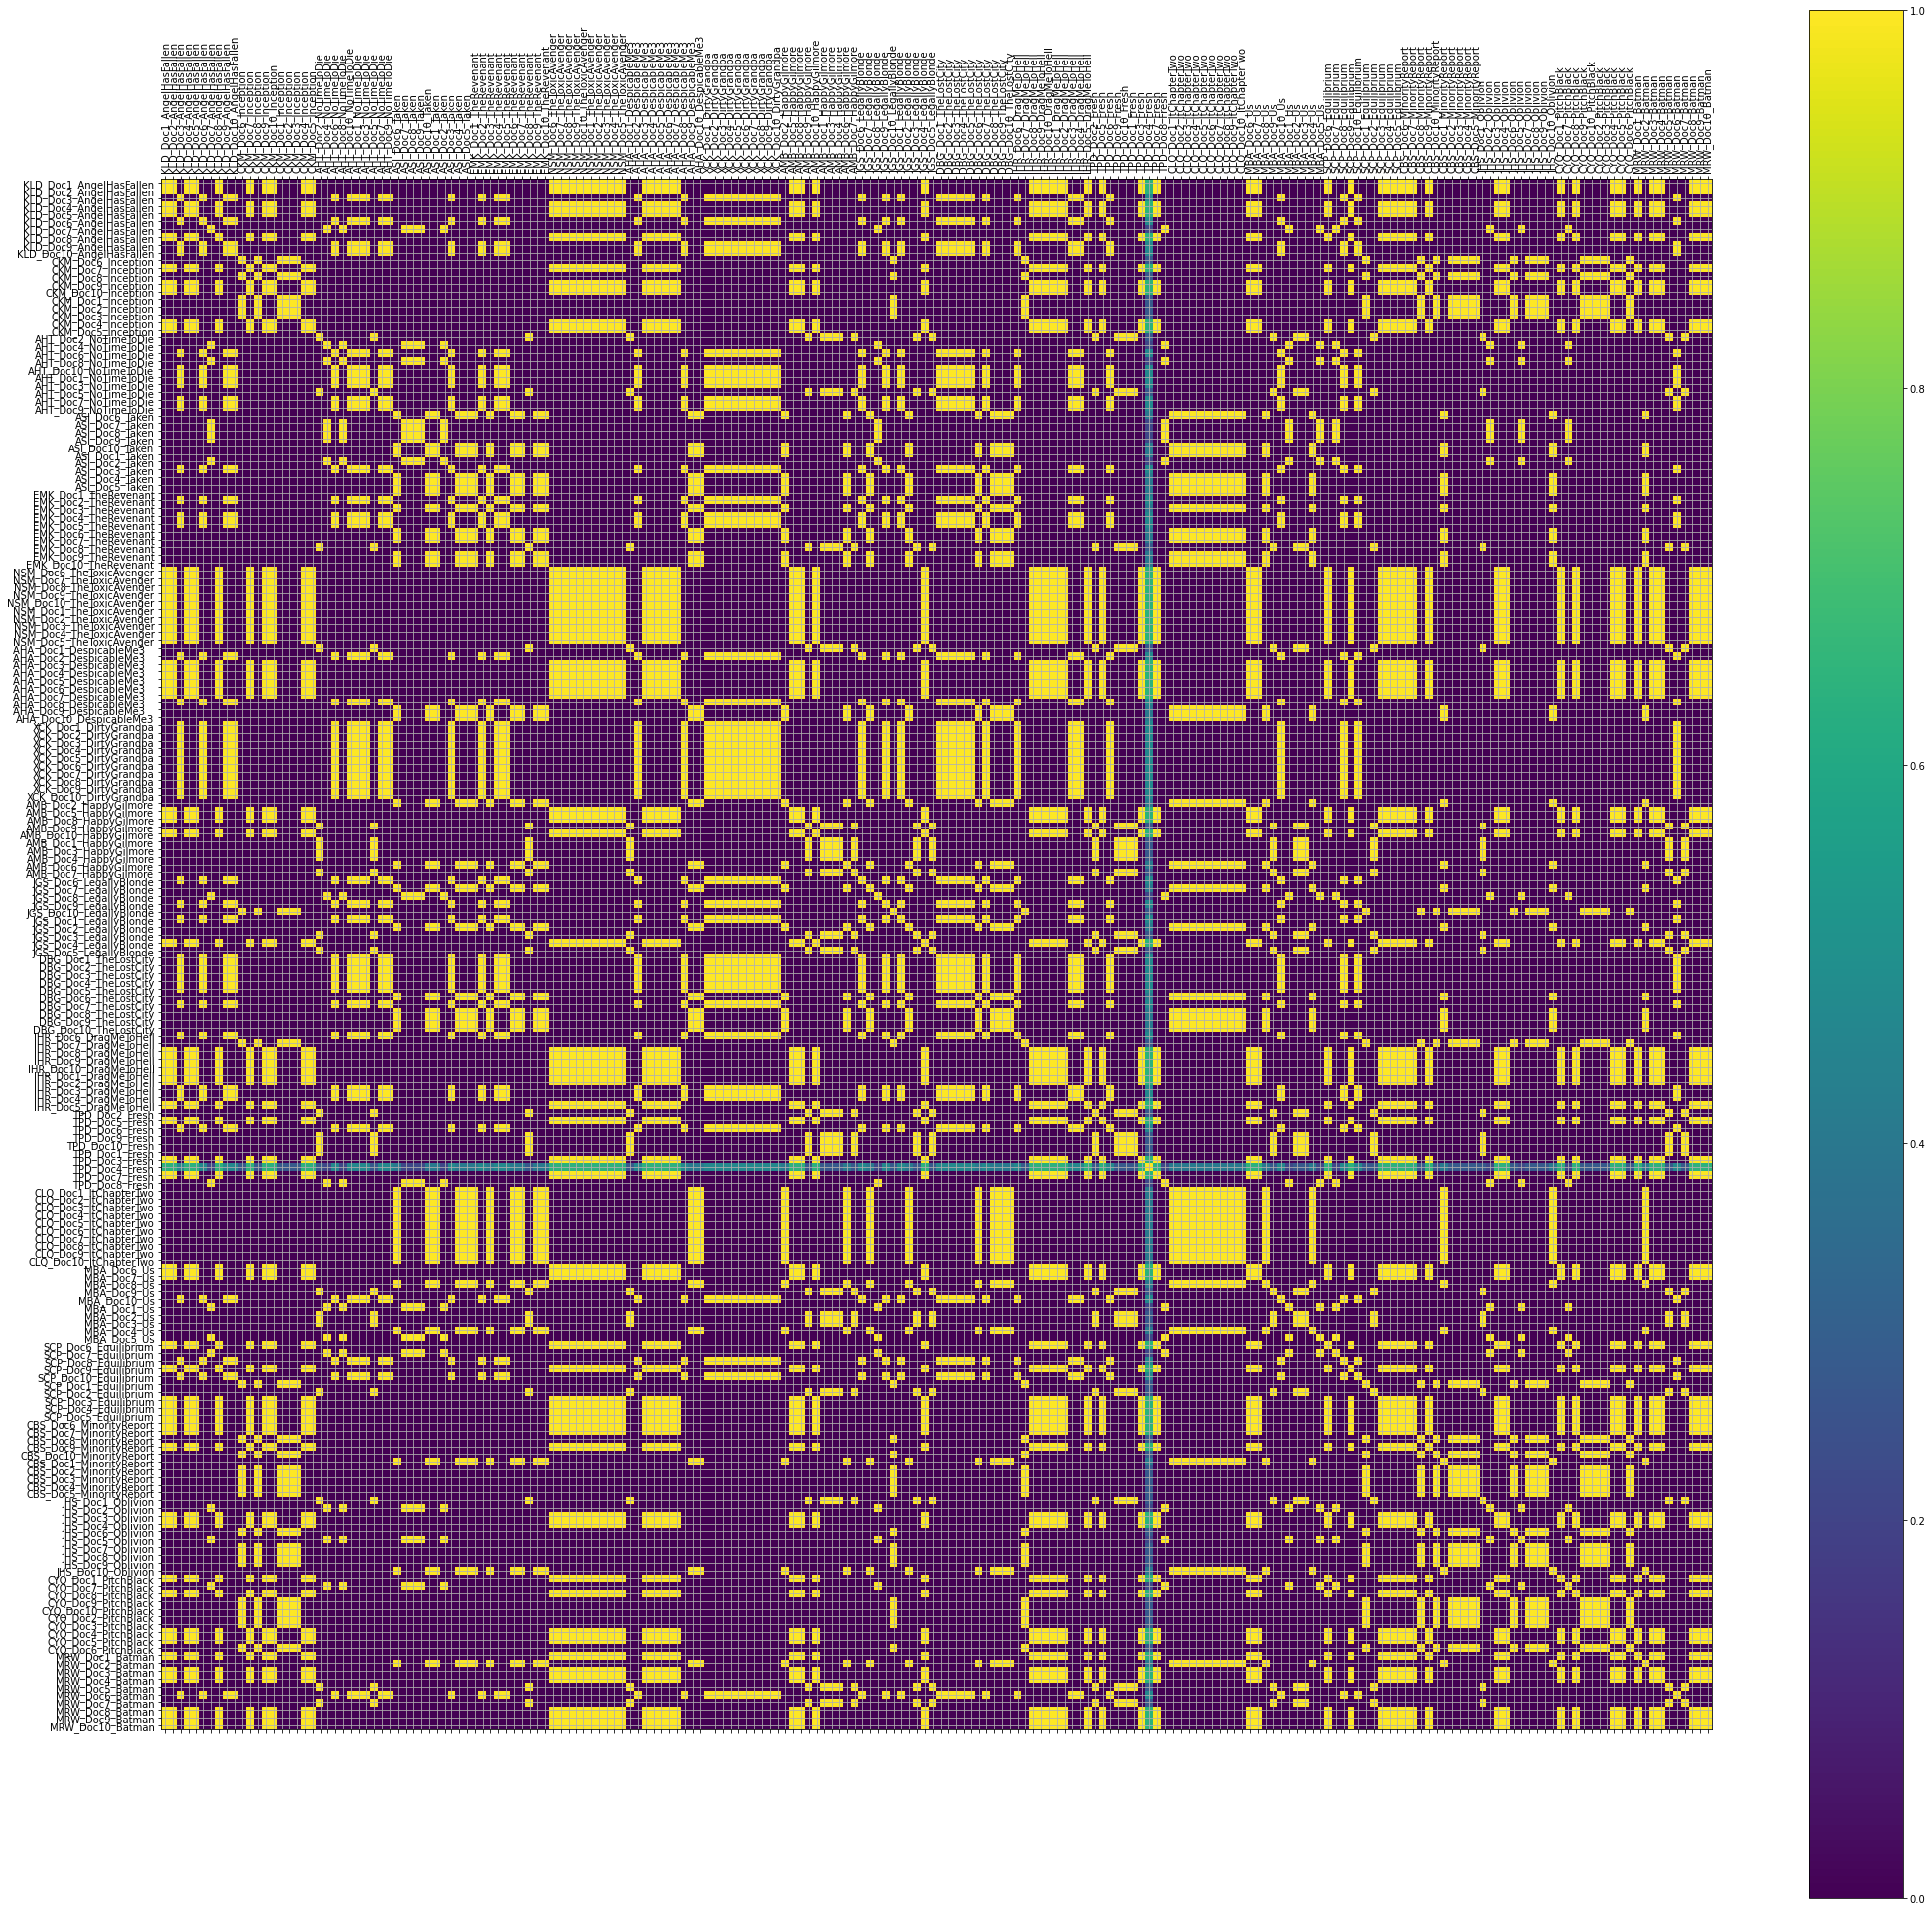

In [31]:
model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics,words)

for doc in processed_text:
    vec_bow2 = dictionary2.doc2bow(doc)
    vec2 = model2[vec_bow2]  # convert the query to embedded space
    sims2 = index2[vec2]  # perform a similarity query against the corpus
    #print(list(enumerate(sims2)))  

fig, ax = plt.subplots(figsize=(35, 35))
cax = ax.matshow(index2, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

In [32]:
######################################
#EXPERIMENT WITH THESE PARAMETERS
number_of_topics=20
words=10
#####################################

[(0, '0.007*"glass" + 0.006*"pennywise" + 0.006*"movie" + 0.006*"chapter" + 0.005*"story" + 0.005*"first" + 0.004*"characters" + 0.003*"muschietti" + 0.003*"revenant" + 0.003*"another"'), (1, '0.010*"inception" + 0.009*"nolan" + 0.008*"movie" + 0.005*"dreams" + 0.004*"dream" + 0.003*"subconscious" + 0.003*"could" + 0.003*"story" + 0.003*"world" + 0.003*"dicaprio"'), (2, '0.007*"movie" + 0.003*"wendy" + 0.003*"character" + 0.003*"fallen" + 0.003*"would" + 0.003*"first" + 0.002*"story" + 0.002*"action" + 0.002*"characters" + 0.002*"people"'), (3, '0.007*"movie" + 0.003*"story" + 0.003*"character" + 0.003*"though" + 0.003*"action" + 0.003*"still" + 0.002*"glass" + 0.002*"first" + 0.002*"banning" + 0.002*"could"'), (4, '0.009*"toxic" + 0.009*"batman" + 0.009*"movie" + 0.006*"avenger" + 0.005*"troma" + 0.004*"melvin" + 0.004*"people" + 0.004*"films" + 0.004*"scene" + 0.003*"story"'), (5, '0.010*"movie" + 0.006*"peele" + 0.005*"action" + 0.004*"first" + 0.003*"horror" + 0.003*"family" + 0.00

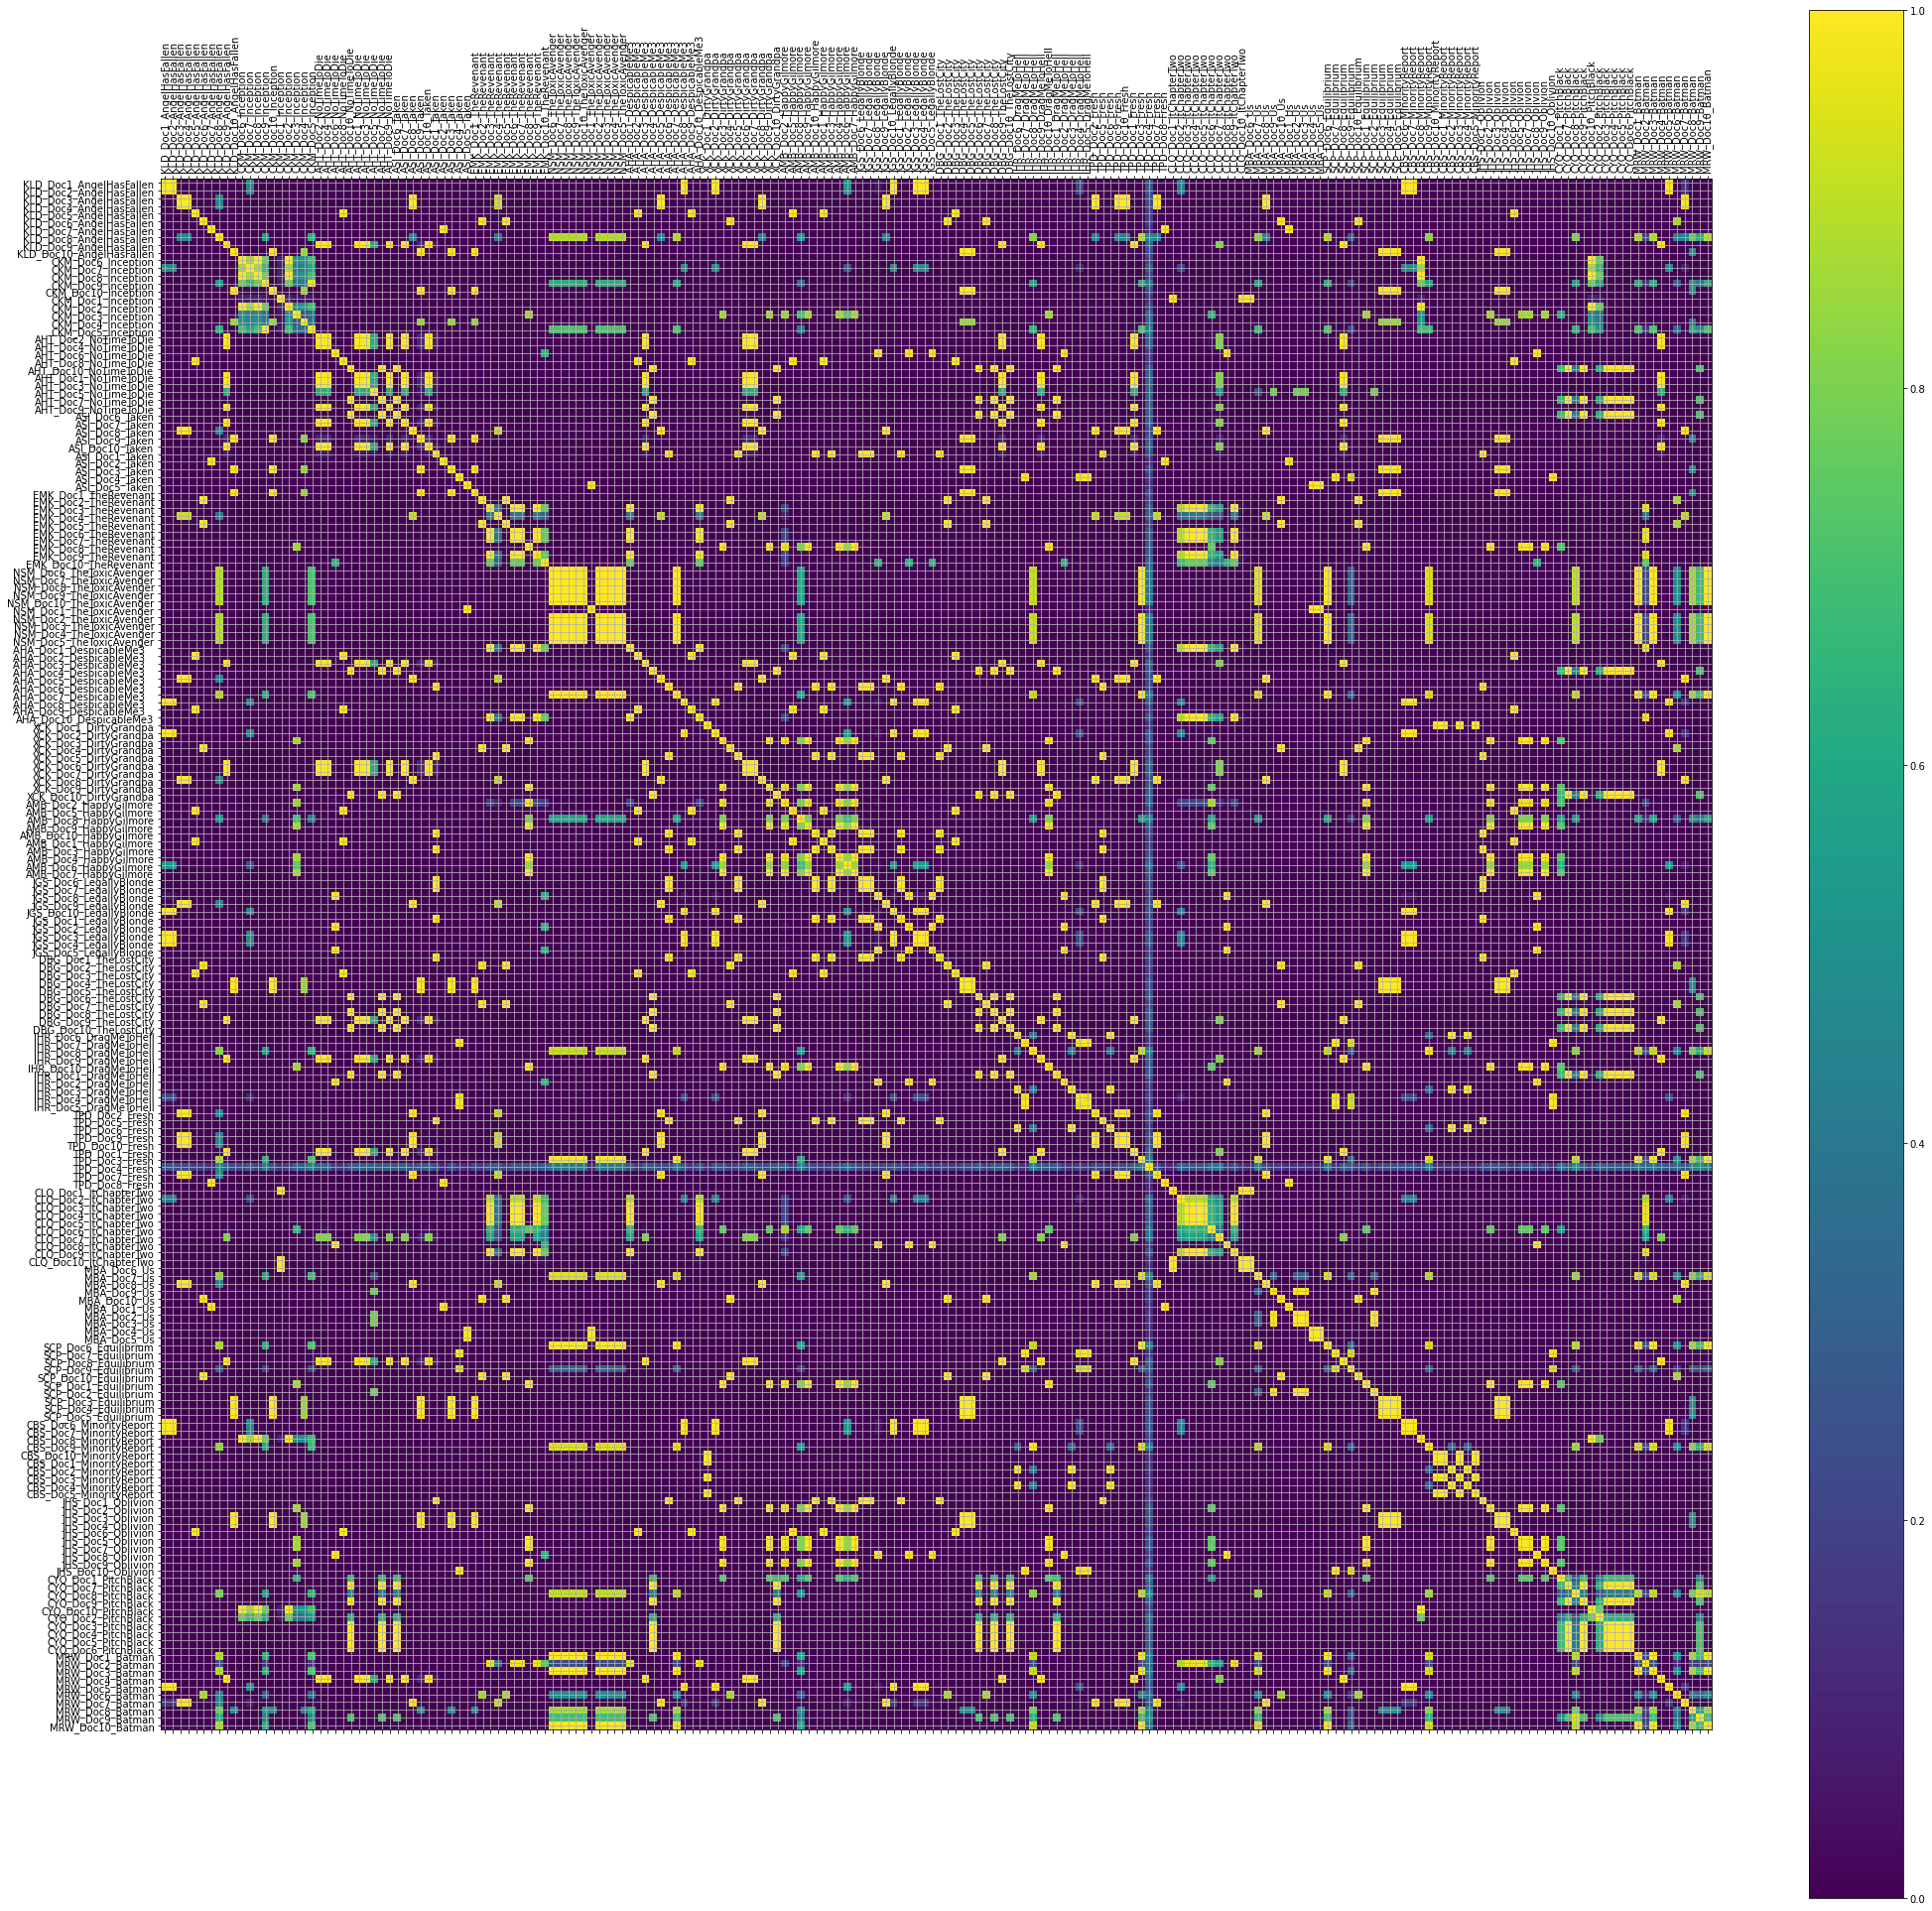

In [33]:
model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics,words)

for doc in processed_text:
    vec_bow2 = dictionary2.doc2bow(doc)
    vec2 = model2[vec_bow2]  # convert the query to embedded space
    sims2 = index2[vec2]  # perform a similarity query against the corpus
    #print(list(enumerate(sims2)))  

fig, ax = plt.subplots(figsize=(35, 35))
cax = ax.matshow(index2, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

### Compare LDA Model Coherence

In [34]:
topics = [2, 4, 6, 20]
coherence_values = []
for t in topics:
    ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10)


    coherence_model_lda = CoherenceModel(model=ldamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

    
coherence ={'2 concepts 10 words':coherence_values[0],
           '4 concepts 10 words': coherence_values[1],
           '6 concepts 10 words':coherence_values[2],
           '20 concepts 10 words':coherence_values[3]}   

print(coherence)

[(0, '0.008*"movie" + 0.003*"first" + 0.003*"batman" + 0.003*"character" + 0.003*"story" + 0.003*"action" + 0.003*"would" + 0.003*"characters" + 0.003*"films" + 0.002*"could"'), (1, '0.008*"movie" + 0.003*"action" + 0.003*"character" + 0.003*"story" + 0.003*"first" + 0.003*"would" + 0.003*"batman" + 0.003*"films" + 0.003*"characters" + 0.002*"could"')]


[(0, '0.008*"movie" + 0.003*"first" + 0.003*"action" + 0.003*"story" + 0.003*"character" + 0.003*"characters" + 0.003*"would" + 0.003*"films" + 0.003*"horror" + 0.002*"movies"'), (1, '0.008*"movie" + 0.003*"story" + 0.003*"would" + 0.003*"action" + 0.003*"character" + 0.003*"first" + 0.003*"films" + 0.003*"world" + 0.003*"characters" + 0.003*"people"'), (2, '0.009*"movie" + 0.003*"action" + 0.003*"character" + 0.003*"would" + 0.003*"first" + 0.003*"story" + 0.002*"films" + 0.002*"characters" + 0.002*"could" + 0.002*"movies"'), (3, '0.009*"movie" + 0.004*"batman" + 0.003*"character" + 0.003*"story" + 0.003*"first" + 0.003*"action" + 0.003*"characters" + 0.003*"would" + 0.003*"films" + 0.002*"could"')]


[(0, '0.008*"movie" + 0.004*"first" + 0.003*"story" + 0.003*"character" + 0.003*"action" + 0.003*"characters" + 0.002*"could" + 0.002*"films" + 0.002*"never" + 0.002*"would"'), (1, '0.007*"movie" + 0.003*"story" + 0.003*"action" + 0.003*"would" + 0.003*"character" + 0.003*"anderton" + 0.003*"first" + 0.003*"films" + 0.003*"world" + 0.003*"nolan"'), (2, '0.008*"movie" + 0.003*"character" + 0.003*"would" + 0.003*"action" + 0.003*"first" + 0.003*"story" + 0.003*"characters" + 0.002*"films" + 0.002*"could" + 0.002*"years"'), (3, '0.008*"movie" + 0.003*"character" + 0.003*"action" + 0.003*"first" + 0.003*"story" + 0.003*"films" + 0.002*"characters" + 0.002*"would" + 0.002*"could" + 0.002*"still"'), (4, '0.010*"movie" + 0.004*"batman" + 0.003*"toxic" + 0.003*"would" + 0.003*"first" + 0.003*"action" + 0.003*"films" + 0.003*"character" + 0.003*"story" + 0.003*"movies"'), (5, '0.009*"movie" + 0.004*"batman" + 0.004*"character" + 0.003*"first" + 0.003*"action" + 0.003*"happy" + 0.003*"would" + 0

[(0, '0.007*"glass" + 0.006*"pennywise" + 0.006*"movie" + 0.006*"chapter" + 0.005*"story" + 0.005*"first" + 0.004*"characters" + 0.003*"muschietti" + 0.003*"revenant" + 0.003*"another"'), (1, '0.010*"inception" + 0.009*"nolan" + 0.008*"movie" + 0.005*"dreams" + 0.004*"dream" + 0.003*"subconscious" + 0.003*"could" + 0.003*"story" + 0.003*"world" + 0.003*"dicaprio"'), (2, '0.007*"movie" + 0.003*"wendy" + 0.003*"character" + 0.003*"fallen" + 0.003*"would" + 0.003*"first" + 0.002*"story" + 0.002*"action" + 0.002*"characters" + 0.002*"people"'), (3, '0.007*"movie" + 0.003*"story" + 0.003*"character" + 0.003*"though" + 0.003*"action" + 0.003*"still" + 0.002*"glass" + 0.002*"first" + 0.002*"banning" + 0.002*"could"'), (4, '0.009*"toxic" + 0.009*"batman" + 0.009*"movie" + 0.006*"avenger" + 0.005*"troma" + 0.004*"melvin" + 0.004*"people" + 0.004*"films" + 0.004*"scene" + 0.003*"story"'), (5, '0.010*"movie" + 0.006*"peele" + 0.005*"action" + 0.004*"first" + 0.003*"horror" + 0.003*"family" + 0.00

## NLP Supervised and Unsupervised Learning Methods:
1. K-Means Clustering (Unsupervised)
2. Support Vector Machines (SVMs) (Supervised)
3. (Multinomial) Naïve Bayes (MultinomialNB) (Supervised)
4. Logistic Regression (Supervised)

## Cluster Model Research: KMeans, SVM, Logistic, Naive Bayes, Randomforest

### Generate TF-IDF For Analysis

In [ ]:
tfidf_matrix = tfidf(final_processed_text, titles, ngram_range = (1,1))



### KMeans Clustering

<div class="alert alert-block alert-success">
    <b>sklearn.cluster.KMeans</b>:<br> 
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html<br><br>
<b>KMeans Default Parameters</b>:<br>
    class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
    </div>

In [ ]:
cluster_title,clusters,k_means_df = k_means(titles, tfidf_matrix, k=5)

In [ ]:

score = silhouette_score(tfidf_matrix,clusters, metric = 'euclidean')

print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.034


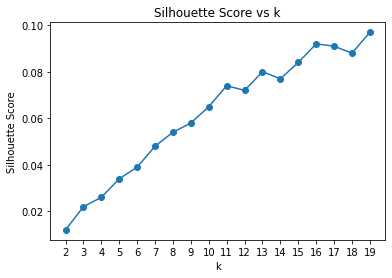

In [ ]:
#create scatterplot of silhouette scores
y = [0.012, 0.022, 0.026, 0.034, 0.039, 0.048, 0.054, 0.058, 0.065, 0.074, 0.072, 0.080, 0.077, 0.084, 0.092, 0.091, 0.088, 0.097]
x = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

import matplotlib.pyplot as plt
plt.scatter(x, y)
plt.title ("Silhouette Score vs k")
plt.ylabel("Silhouette Score")
plt.xlabel("k")
plt.xticks(np.arange(0, 20, 1))
plt.plot(x, y)

### Access Each Cluster - Changing Dictionary KeyValue from 0 to k

In [ ]:
cluster_title[3]

['KLD_Doc1_AngelHasFallen',
 'KLD_Doc2_AngelHasFallen',
 'KLD_Doc3_AngelHasFallen',
 'KLD_Doc4_AngelHasFallen',
 'KLD_Doc5_AngelHasFallen',
 'KLD_Doc6_AngelHasFallen',
 'KLD_Doc7_AngelHasFallen',
 'KLD_Doc8_AngelHasFallen',
 'KLD_Doc9_AngelHasFallen',
 'KLD_Doc10_AngelHasFallen']

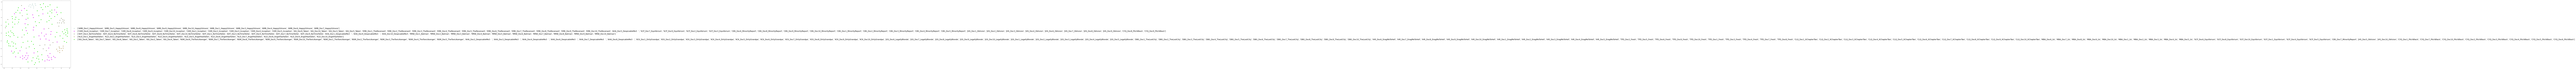

In [ ]:
plot_tfidf_matrix(cluster_title,clusters,tfidf_matrix)

### Generate Labels for Supervised Learning Models

In [ ]:
#Sentiment Analysis with SVM and tf-idf
labels = data['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)
print(labels)

Doc_ID
60     0
61     0
62     0
63     0
64     0
      ..
115    1
116    1
117    1
118    1
119    1
Name: Review Type (pos or neg), Length: 200, dtype: int64


In [ ]:
labels.value_counts()

0    100
1    100
Name: Review Type (pos or neg), dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, labels,
                                                    test_size=0.33,
                                                    random_state=20130810)

### Support Vector Machines 

<div class="alert alert-block alert-success">
    <b>Support vector machines (SVMs)</b>:<br> 
https://scikit-learn.org/stable/modules/svm.html<br><br>
    Set of supervised learning methods used for classification, regression and outliers detection
    </div>

In [ ]:
#Sentiment Analysis SVM tf-idf
model_svm = SVC()

In [ ]:
model_svm.fit(X_train, y_train)

SVC()

In [ ]:
y_pred = model_svm.predict(X_test)

In [ ]:
y_pred

array([1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0])

In [ ]:
accuracy_score(y_test, y_pred)

0.4696969696969697

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.67      0.56        33
           1       0.45      0.27      0.34        33

    accuracy                           0.47        66
   macro avg       0.46      0.47      0.45        66
weighted avg       0.46      0.47      0.45        66



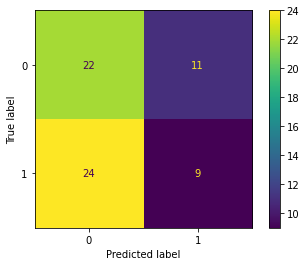

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
for C_value in [0.01, 0.1, 1, 10, 100, 1000, 10000]:
    
    model_svm = SVC(C=C_value)
    model_svm.fit(X_train, y_train)
    y_pred = model_svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred) 
    print(f"C: {C_value}, Accuracy: {acc}")

C: 0.01, Accuracy: 0.4696969696969697
C: 0.1, Accuracy: 0.4696969696969697
C: 1, Accuracy: 0.4696969696969697
C: 10, Accuracy: 0.45454545454545453
C: 100, Accuracy: 0.45454545454545453
C: 1000, Accuracy: 0.45454545454545453
C: 10000, Accuracy: 0.45454545454545453


In [ ]:
model_svm = SVC(C=0.01)
model_svm.fit(X_train, y_train)

SVC(C=0.01)

In [ ]:
model_svm.predict(X_test)

array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0])

In [ ]:
classifiers(tfidf_matrix, labels, 'svm')

svm


0.36363636363636365

In [ ]:
#Multi-class classification with SVM and tf-idf
labels = corpus_df['Genre of Movie']

In [ ]:
labels.value_counts()

Action    60
Comedy    50
Sci-Fi    50
Horror    40
Name: Genre of Movie, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, labels,
                                                    test_size=0.33,
                                                    stratify=labels,
                                                    random_state=20130810)

In [ ]:
y_test.value_counts()

Action    20
Comedy    17
Sci-Fi    16
Horror    13
Name: Genre of Movie, dtype: int64

In [ ]:
model_svm = SVC()

In [ ]:
model_svm.fit(X_train, y_train)

SVC()

In [ ]:
y_pred = model_svm.predict(X_test)

In [ ]:
y_pred

array(['Action', 'Sci-Fi', 'Horror', 'Sci-Fi', 'Comedy', 'Action',
       'Action', 'Sci-Fi', 'Comedy', 'Sci-Fi', 'Action', 'Action',
       'Sci-Fi', 'Comedy', 'Sci-Fi', 'Action', 'Horror', 'Horror',
       'Action', 'Sci-Fi', 'Comedy', 'Horror', 'Horror', 'Action',
       'Sci-Fi', 'Action', 'Action', 'Sci-Fi', 'Sci-Fi', 'Horror',
       'Action', 'Action', 'Comedy', 'Action', 'Comedy', 'Horror',
       'Action', 'Horror', 'Action', 'Comedy', 'Action', 'Horror',
       'Action', 'Action', 'Action', 'Sci-Fi', 'Action', 'Action',
       'Comedy', 'Horror', 'Action', 'Comedy', 'Comedy', 'Horror',
       'Sci-Fi', 'Action', 'Comedy', 'Action', 'Comedy', 'Sci-Fi',
       'Sci-Fi', 'Comedy', 'Comedy', 'Action', 'Sci-Fi', 'Sci-Fi'],
      dtype=object)

In [ ]:
accuracy_score(y_test, y_pred)

0.9242424242424242

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Action       0.80      1.00      0.89        20
      Comedy       1.00      0.82      0.90        17
      Horror       1.00      0.85      0.92        13
      Sci-Fi       1.00      1.00      1.00        16

    accuracy                           0.92        66
   macro avg       0.95      0.92      0.93        66
weighted avg       0.94      0.92      0.92        66



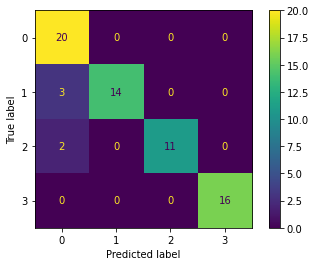

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
for C_value in [0.01, 0.1, 1, 10, 100, 1000, 10000]:
    model_svm = SVC(C=C_value)
    model_svm.fit(X_train, y_train)
    y_pred = model_svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred) 
    print(f"C: {C_value}, Accuracy: {acc}")

C: 0.01, Accuracy: 0.30303030303030304
C: 0.1, Accuracy: 0.30303030303030304
C: 1, Accuracy: 0.9242424242424242
C: 10, Accuracy: 0.9242424242424242
C: 100, Accuracy: 0.9242424242424242
C: 1000, Accuracy: 0.9242424242424242
C: 10000, Accuracy: 0.9242424242424242


In [ ]:
model_svm = SVC(C=1)
model_svm.fit(X_train, y_train)

SVC(C=1)

In [ ]:
model_svm.predict(X_test)

array(['Action', 'Sci-Fi', 'Horror', 'Sci-Fi', 'Comedy', 'Action',
       'Action', 'Sci-Fi', 'Comedy', 'Sci-Fi', 'Action', 'Action',
       'Sci-Fi', 'Comedy', 'Sci-Fi', 'Action', 'Horror', 'Horror',
       'Action', 'Sci-Fi', 'Comedy', 'Horror', 'Horror', 'Action',
       'Sci-Fi', 'Action', 'Action', 'Sci-Fi', 'Sci-Fi', 'Horror',
       'Action', 'Action', 'Comedy', 'Action', 'Comedy', 'Horror',
       'Action', 'Horror', 'Action', 'Comedy', 'Action', 'Horror',
       'Action', 'Action', 'Action', 'Sci-Fi', 'Action', 'Action',
       'Comedy', 'Horror', 'Action', 'Comedy', 'Comedy', 'Horror',
       'Sci-Fi', 'Action', 'Comedy', 'Action', 'Comedy', 'Sci-Fi',
       'Sci-Fi', 'Comedy', 'Comedy', 'Action', 'Sci-Fi', 'Sci-Fi'],
      dtype=object)

### Logistic Regression Model 

<div class="alert alert-block alert-success">
    <b>sklearn.linear_model.LogisticRegression</b>:<br> 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html<br><br>
<b>Logistic Regression Default Parameters</b>:<br>
    class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
    </div>

In [ ]:
#Logistic Regression for Sentiment tf-idf
labels = data['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)
print(labels)
model_lr = LogisticRegression(solver = 'newton-cg', random_state = 0)

Doc_ID
60     0
61     0
62     0
63     0
64     0
      ..
115    1
116    1
117    1
118    1
119    1
Name: Review Type (pos or neg), Length: 200, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, labels,
                                                    test_size=0.33,
                                                    random_state=20130810)

In [ ]:
model_lr.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='newton-cg')

In [ ]:
y_pred = model_lr.predict(X_test)

In [ ]:
y_pred

array([1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1])

In [ ]:
accuracy_score(y_test, y_pred)

0.4696969696969697

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.52      0.49        33
           1       0.47      0.42      0.44        33

    accuracy                           0.47        66
   macro avg       0.47      0.47      0.47        66
weighted avg       0.47      0.47      0.47        66



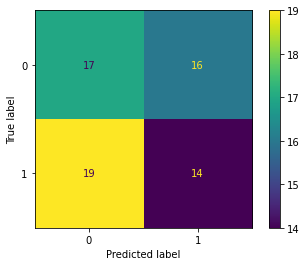

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
#Multi-class classification with logistic regression and tf-idf
labels = corpus_df['Genre of Movie']

In [ ]:
labels.value_counts()

Action    60
Comedy    50
Sci-Fi    50
Horror    40
Name: Genre of Movie, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, labels,
                                                    test_size=0.33,
                                                    stratify=labels,
                                                    random_state=20130810)

In [ ]:
y_test.value_counts()

Action    20
Comedy    17
Sci-Fi    16
Horror    13
Name: Genre of Movie, dtype: int64

In [ ]:
model_lr = LogisticRegression(solver = 'newton-cg', random_state = 0)

In [ ]:
model_lr.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='newton-cg')

In [ ]:
y_pred = model_lr.predict(X_test)

In [ ]:
y_pred

array(['Action', 'Sci-Fi', 'Horror', 'Sci-Fi', 'Comedy', 'Action',
       'Action', 'Sci-Fi', 'Comedy', 'Sci-Fi', 'Action', 'Action',
       'Sci-Fi', 'Comedy', 'Sci-Fi', 'Action', 'Horror', 'Horror',
       'Action', 'Sci-Fi', 'Comedy', 'Horror', 'Horror', 'Action',
       'Sci-Fi', 'Action', 'Action', 'Sci-Fi', 'Sci-Fi', 'Horror',
       'Action', 'Action', 'Comedy', 'Action', 'Comedy', 'Horror',
       'Action', 'Horror', 'Action', 'Comedy', 'Action', 'Horror',
       'Action', 'Action', 'Action', 'Sci-Fi', 'Action', 'Action',
       'Comedy', 'Horror', 'Action', 'Comedy', 'Comedy', 'Horror',
       'Sci-Fi', 'Action', 'Comedy', 'Action', 'Comedy', 'Sci-Fi',
       'Sci-Fi', 'Comedy', 'Comedy', 'Action', 'Sci-Fi', 'Sci-Fi'],
      dtype=object)

In [ ]:
accuracy_score(y_test, y_pred)

0.9242424242424242

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Action       0.80      1.00      0.89        20
      Comedy       1.00      0.82      0.90        17
      Horror       1.00      0.85      0.92        13
      Sci-Fi       1.00      1.00      1.00        16

    accuracy                           0.92        66
   macro avg       0.95      0.92      0.93        66
weighted avg       0.94      0.92      0.92        66



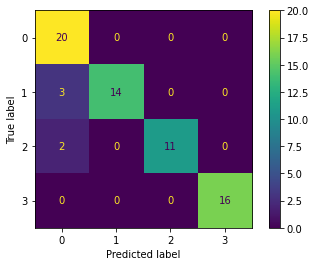

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
classifiers(tfidf_matrix, labels, 'logistic')

logistic


0.8181818181818182

### Naive Bayes

<div class="alert alert-block alert-success">
    <b>Naive Bayes</b>:<br> 
https://scikit-learn.org/stable/modules/naive_bayes.html<br><br>
    Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.
    </div>

In [ ]:
#Sentiment Analysis with Naive Bayes and TF-IDF
labels = data['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)
print(labels)
model_nb = MultinomialNB()

Doc_ID
60     0
61     0
62     0
63     0
64     0
      ..
115    1
116    1
117    1
118    1
119    1
Name: Review Type (pos or neg), Length: 200, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, labels,
                                                    test_size=0.33,
                                                    random_state=20130810)

In [ ]:
model_nb.fit(X_train, y_train)

MultinomialNB()

In [ ]:
y_pred = model_nb.predict(X_test)

In [ ]:
y_pred

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1])

In [ ]:
accuracy_score(y_test, y_pred)

0.3939393939393939

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.36      0.27      0.31        33
           1       0.41      0.52      0.46        33

    accuracy                           0.39        66
   macro avg       0.39      0.39      0.38        66
weighted avg       0.39      0.39      0.38        66



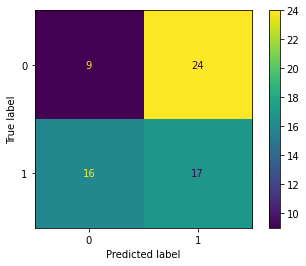

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
#Multi-class classification with NB and tf-idf
labels = corpus_df['Genre of Movie']

In [ ]:
labels.value_counts()

Action    60
Comedy    50
Sci-Fi    50
Horror    40
Name: Genre of Movie, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, labels,
                                                    test_size=0.33,
                                                    stratify=labels,
                                                    random_state=20130810)

In [ ]:
y_test.value_counts()

Action    20
Comedy    17
Sci-Fi    16
Horror    13
Name: Genre of Movie, dtype: int64

In [ ]:
model_nb = MultinomialNB()

In [ ]:
model_nb.fit(X_train, y_train)

MultinomialNB()

In [ ]:
y_pred = model_nb.predict(X_test)

In [ ]:
y_pred

array(['Action', 'Sci-Fi', 'Action', 'Sci-Fi', 'Comedy', 'Action',
       'Action', 'Sci-Fi', 'Comedy', 'Sci-Fi', 'Action', 'Action',
       'Sci-Fi', 'Comedy', 'Sci-Fi', 'Action', 'Horror', 'Horror',
       'Action', 'Sci-Fi', 'Comedy', 'Horror', 'Horror', 'Action',
       'Sci-Fi', 'Action', 'Action', 'Sci-Fi', 'Sci-Fi', 'Horror',
       'Action', 'Action', 'Comedy', 'Action', 'Comedy', 'Horror',
       'Action', 'Horror', 'Action', 'Comedy', 'Action', 'Horror',
       'Action', 'Action', 'Action', 'Sci-Fi', 'Action', 'Action',
       'Comedy', 'Horror', 'Action', 'Comedy', 'Comedy', 'Horror',
       'Sci-Fi', 'Action', 'Comedy', 'Action', 'Comedy', 'Sci-Fi',
       'Sci-Fi', 'Comedy', 'Comedy', 'Action', 'Sci-Fi', 'Sci-Fi'],
      dtype='<U6')

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Action       0.77      1.00      0.87        20
      Comedy       1.00      0.82      0.90        17
      Horror       1.00      0.77      0.87        13
      Sci-Fi       1.00      1.00      1.00        16

    accuracy                           0.91        66
   macro avg       0.94      0.90      0.91        66
weighted avg       0.93      0.91      0.91        66



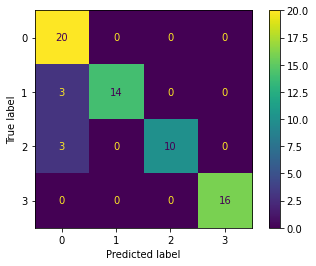

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
classifiers(tfidf_matrix, labels, 'naive_bayes')

naive_bayes


0.7727272727272727

### Random Forest

<div class="alert alert-block alert-success">
    <b>sklearn.ensemble.RandomForestClassifier</b>:<br> 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html<br><br>
<b>RandomForest Classifier Default Parameters</b>:<br>
    class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
    </div>

In [ ]:
classifiers(tfidf_matrix, labels, 'randomforest')

randomforest


0.8787878787878788

In [ ]:
#Random Forest for Sentiment tf-idf
labels = data['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)
print(labels)
model_rf = RandomForestClassifier()

Doc_ID
60     0
61     0
62     0
63     0
64     0
      ..
115    1
116    1
117    1
118    1
119    1
Name: Review Type (pos or neg), Length: 200, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, labels,
                                                    test_size=0.33,
                                                    random_state=20130810)

In [ ]:
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = model_rf.predict(X_test)

In [ ]:
y_pred

array([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [ ]:
accuracy_score(y_test, y_pred)

0.5

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.30      0.38        33
           1       0.50      0.70      0.58        33

    accuracy                           0.50        66
   macro avg       0.50      0.50      0.48        66
weighted avg       0.50      0.50      0.48        66



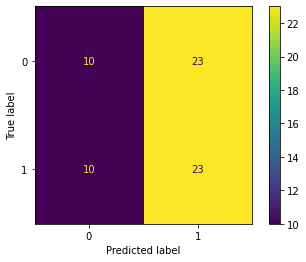

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
#Multi-class classification with random forest and tf-idf
labels = corpus_df['Genre of Movie']

In [ ]:
labels.value_counts()

Action    60
Comedy    50
Sci-Fi    50
Horror    40
Name: Genre of Movie, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, labels,
                                                    test_size=0.33,
                                                    stratify=labels,
                                                    random_state=20130810)

In [ ]:
y_test.value_counts()

Action    20
Comedy    17
Sci-Fi    16
Horror    13
Name: Genre of Movie, dtype: int64

In [ ]:
model_rf = RandomForestClassifier()

In [ ]:
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = model_rf.predict(X_test)

In [ ]:
y_pred

array(['Action', 'Sci-Fi', 'Horror', 'Sci-Fi', 'Comedy', 'Action',
       'Comedy', 'Sci-Fi', 'Comedy', 'Sci-Fi', 'Action', 'Horror',
       'Sci-Fi', 'Comedy', 'Comedy', 'Action', 'Horror', 'Horror',
       'Action', 'Sci-Fi', 'Comedy', 'Horror', 'Horror', 'Comedy',
       'Sci-Fi', 'Comedy', 'Comedy', 'Sci-Fi', 'Sci-Fi', 'Horror',
       'Action', 'Action', 'Comedy', 'Action', 'Comedy', 'Horror',
       'Action', 'Horror', 'Comedy', 'Comedy', 'Action', 'Horror',
       'Action', 'Action', 'Comedy', 'Sci-Fi', 'Action', 'Action',
       'Comedy', 'Horror', 'Action', 'Comedy', 'Comedy', 'Horror',
       'Sci-Fi', 'Action', 'Comedy', 'Action', 'Comedy', 'Sci-Fi',
       'Sci-Fi', 'Comedy', 'Comedy', 'Action', 'Sci-Fi', 'Sci-Fi'],
      dtype=object)

In [ ]:
accuracy_score(y_test, y_pred)

0.9393939393939394

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Action       1.00      0.90      0.95        20
      Comedy       0.81      1.00      0.89        17
      Horror       1.00      0.92      0.96        13
      Sci-Fi       1.00      0.94      0.97        16

    accuracy                           0.94        66
   macro avg       0.95      0.94      0.94        66
weighted avg       0.95      0.94      0.94        66



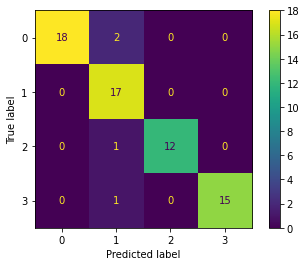

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
#Doc2Vec feature extraction

In [ ]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text)]

In [ ]:
model_doc2vec = Doc2Vec(documents,
                        vector_size=200,
                        min_count=1,
                        workers=4)

In [ ]:
features_doc2vec = pd.DataFrame()

for document in documents:
    vector = pd.DataFrame(model_doc2vec.infer_vector(document.words)).transpose()
    features_doc2vec = pd.concat([features_doc2vec, vector])

In [ ]:
features_doc2vec.shape

(200, 200)

In [ ]:
#Sentiment Analysis SVM Doc2Vec 200
labels = data['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)
print(labels)

Doc_ID
60     0
61     0
62     0
63     0
64     0
      ..
115    1
116    1
117    1
118    1
119    1
Name: Review Type (pos or neg), Length: 200, dtype: int64


In [ ]:
labels.value_counts()

0    100
1    100
Name: Review Type (pos or neg), dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_doc2vec, labels,
                                                    test_size=0.33,
                                                    random_state=20130810)

In [ ]:
model_svm = SVC()

In [ ]:
model_svm.fit(X_train, y_train)

SVC()

In [ ]:
y_pred = model_svm.predict(X_test)

In [ ]:
y_pred

array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

In [ ]:
accuracy_score(y_test, y_pred)

0.5

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.39      0.44        33
           1       0.50      0.61      0.55        33

    accuracy                           0.50        66
   macro avg       0.50      0.50      0.49        66
weighted avg       0.50      0.50      0.49        66



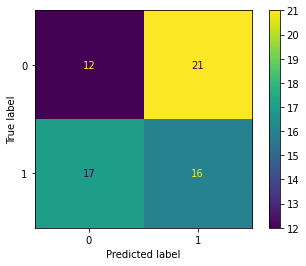

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
for C_value in [0.01, 0.1, 1, 10, 100, 1000, 10000]:
    
    model_svm = SVC(C=C_value)
    model_svm.fit(X_train, y_train)
    y_pred = model_svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred) 
    print(f"C: {C_value}, Accuracy: {acc}")

C: 0.01, Accuracy: 0.48484848484848486
C: 0.1, Accuracy: 0.48484848484848486
C: 1, Accuracy: 0.5
C: 10, Accuracy: 0.48484848484848486
C: 100, Accuracy: 0.5303030303030303
C: 1000, Accuracy: 0.42424242424242425
C: 10000, Accuracy: 0.42424242424242425


In [ ]:
model_svm = SVC(C=10)
model_svm.fit(X_train, y_train)

SVC(C=10)

In [ ]:
model_svm.predict(X_test)

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0])

In [ ]:
#Sentiment Analysis Logistic Regression Doc2Vec 200
model_lr = LogisticRegression(solver = 'newton-cg', random_state = 0)

In [ ]:
model_lr.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='newton-cg')

In [ ]:
y_pred = model_lr.predict(X_test)

In [ ]:
y_pred

array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1])

In [ ]:
accuracy_score(y_test, y_pred)

0.4696969696969697

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.33      0.39        33
           1       0.48      0.61      0.53        33

    accuracy                           0.47        66
   macro avg       0.47      0.47      0.46        66
weighted avg       0.47      0.47      0.46        66



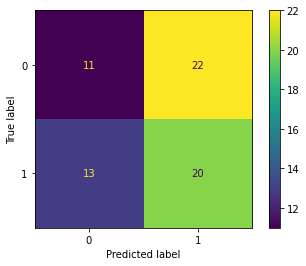

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
#Sentiment Analysis Naive Bayes Doc2Vec 200
model_gnb = GaussianNB()

In [ ]:
model_gnb.fit(X_train, y_train)

GaussianNB()

In [ ]:
y_pred = model_gnb.predict(X_test)

In [ ]:
y_pred

array([1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0])

In [ ]:
accuracy_score(y_test, y_pred)

0.5454545454545454

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.45      0.50        33
           1       0.54      0.64      0.58        33

    accuracy                           0.55        66
   macro avg       0.55      0.55      0.54        66
weighted avg       0.55      0.55      0.54        66



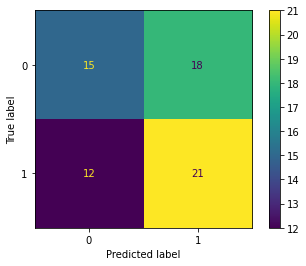

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
#Sentiment Analysis Random Forest Doc2Vec 200
model_rf = RandomForestClassifier()

In [ ]:
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = model_rf.predict(X_test)

In [ ]:
y_pred

array([1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1])

In [ ]:
accuracy_score(y_test, y_pred)

0.4696969696969697

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.42      0.44        33
           1       0.47      0.52      0.49        33

    accuracy                           0.47        66
   macro avg       0.47      0.47      0.47        66
weighted avg       0.47      0.47      0.47        66



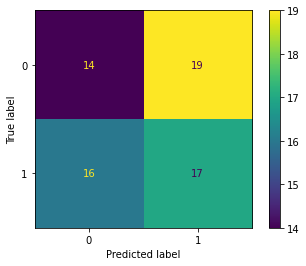

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
#Multi-class classification SVM Doc2Vec 200
labels = corpus_df['Genre of Movie']

In [ ]:
labels.value_counts()

Action    60
Comedy    50
Sci-Fi    50
Horror    40
Name: Genre of Movie, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_doc2vec, labels,
                                                    test_size=0.33,
                                                    stratify=labels,
                                                    random_state=20130810)

In [ ]:
y_test.value_counts()

Action    20
Comedy    17
Sci-Fi    16
Horror    13
Name: Genre of Movie, dtype: int64

In [ ]:
model_svm = SVC()

In [ ]:
model_svm.fit(X_train, y_train)

SVC()

In [ ]:
y_pred = model_svm.predict(X_test)

In [ ]:
y_pred

array(['Comedy', 'Comedy', 'Action', 'Action', 'Comedy', 'Sci-Fi',
       'Comedy', 'Sci-Fi', 'Action', 'Sci-Fi', 'Action', 'Comedy',
       'Sci-Fi', 'Horror', 'Action', 'Action', 'Comedy', 'Action',
       'Action', 'Sci-Fi', 'Action', 'Action', 'Horror', 'Comedy',
       'Action', 'Action', 'Comedy', 'Comedy', 'Sci-Fi', 'Sci-Fi',
       'Action', 'Action', 'Action', 'Action', 'Comedy', 'Action',
       'Action', 'Comedy', 'Action', 'Comedy', 'Comedy', 'Sci-Fi',
       'Action', 'Action', 'Action', 'Action', 'Sci-Fi', 'Sci-Fi',
       'Comedy', 'Action', 'Action', 'Comedy', 'Comedy', 'Action',
       'Sci-Fi', 'Comedy', 'Comedy', 'Action', 'Comedy', 'Sci-Fi',
       'Action', 'Comedy', 'Comedy', 'Action', 'Sci-Fi', 'Action'],
      dtype=object)

In [ ]:
accuracy_score(y_test, y_pred)

0.5303030303030303

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Action       0.47      0.70      0.56        20
      Comedy       0.57      0.71      0.63        17
      Horror       0.50      0.08      0.13        13
      Sci-Fi       0.62      0.50      0.55        16

    accuracy                           0.53        66
   macro avg       0.54      0.50      0.47        66
weighted avg       0.54      0.53      0.49        66



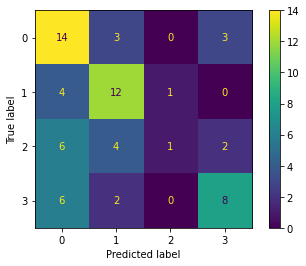

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
for C_value in [0.01, 0.1, 1, 10, 100, 1000, 10000]:
    model_svm = SVC(C=C_value)
    model_svm.fit(X_train, y_train)
    y_pred = model_svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred) 
    print(f"C: {C_value}, Accuracy: {acc}")

C: 0.01, Accuracy: 0.30303030303030304
C: 0.1, Accuracy: 0.30303030303030304
C: 1, Accuracy: 0.5303030303030303
C: 10, Accuracy: 0.5151515151515151
C: 100, Accuracy: 0.4090909090909091
C: 1000, Accuracy: 0.4696969696969697
C: 10000, Accuracy: 0.4696969696969697


In [ ]:
model_svm = SVC(C=1)
model_svm.fit(X_train, y_train)

SVC(C=1)

In [ ]:
model_svm.predict(X_test)

array(['Comedy', 'Comedy', 'Action', 'Action', 'Comedy', 'Sci-Fi',
       'Comedy', 'Sci-Fi', 'Action', 'Sci-Fi', 'Action', 'Comedy',
       'Sci-Fi', 'Horror', 'Action', 'Action', 'Comedy', 'Action',
       'Action', 'Sci-Fi', 'Action', 'Action', 'Horror', 'Comedy',
       'Action', 'Action', 'Comedy', 'Comedy', 'Sci-Fi', 'Sci-Fi',
       'Action', 'Action', 'Action', 'Action', 'Comedy', 'Action',
       'Action', 'Comedy', 'Action', 'Comedy', 'Comedy', 'Sci-Fi',
       'Action', 'Action', 'Action', 'Action', 'Sci-Fi', 'Sci-Fi',
       'Comedy', 'Action', 'Action', 'Comedy', 'Comedy', 'Action',
       'Sci-Fi', 'Comedy', 'Comedy', 'Action', 'Comedy', 'Sci-Fi',
       'Action', 'Comedy', 'Comedy', 'Action', 'Sci-Fi', 'Action'],
      dtype=object)

In [ ]:
#multi-class classification logistic regression Doc2Vec 200
model_lr = LogisticRegression(solver = 'newton-cg', random_state = 0)

In [ ]:
model_lr.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='newton-cg')

In [ ]:
y_pred = model_lr.predict(X_test)

In [ ]:
y_pred

array(['Comedy', 'Comedy', 'Action', 'Sci-Fi', 'Comedy', 'Action',
       'Comedy', 'Sci-Fi', 'Action', 'Action', 'Action', 'Comedy',
       'Comedy', 'Horror', 'Action', 'Sci-Fi', 'Comedy', 'Action',
       'Action', 'Sci-Fi', 'Action', 'Action', 'Horror', 'Sci-Fi',
       'Sci-Fi', 'Action', 'Comedy', 'Comedy', 'Sci-Fi', 'Sci-Fi',
       'Action', 'Action', 'Action', 'Action', 'Comedy', 'Action',
       'Action', 'Comedy', 'Action', 'Sci-Fi', 'Sci-Fi', 'Sci-Fi',
       'Action', 'Action', 'Sci-Fi', 'Action', 'Sci-Fi', 'Sci-Fi',
       'Comedy', 'Action', 'Action', 'Comedy', 'Comedy', 'Action',
       'Sci-Fi', 'Comedy', 'Comedy', 'Action', 'Comedy', 'Sci-Fi',
       'Action', 'Comedy', 'Comedy', 'Sci-Fi', 'Sci-Fi', 'Action'],
      dtype=object)

In [ ]:
accuracy_score(y_test, y_pred)

0.48484848484848486

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Action       0.48      0.65      0.55        20
      Comedy       0.53      0.59      0.56        17
      Horror       0.50      0.08      0.13        13
      Sci-Fi       0.44      0.50      0.47        16

    accuracy                           0.48        66
   macro avg       0.49      0.45      0.43        66
weighted avg       0.49      0.48      0.45        66



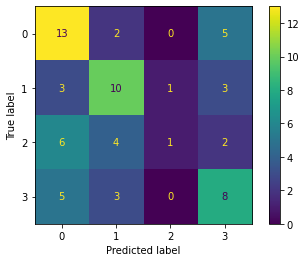

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
#multi-class classification Naive Bayes Doc2Vec 200
model_gnb = GaussianNB()

In [ ]:
model_gnb.fit(X_train, y_train)

GaussianNB()

In [ ]:
y_pred = model_gnb.predict(X_test)

In [ ]:
y_pred

array(['Comedy', 'Comedy', 'Action', 'Comedy', 'Comedy', 'Sci-Fi',
       'Sci-Fi', 'Sci-Fi', 'Action', 'Horror', 'Action', 'Comedy',
       'Sci-Fi', 'Horror', 'Action', 'Sci-Fi', 'Comedy', 'Action',
       'Action', 'Sci-Fi', 'Horror', 'Action', 'Sci-Fi', 'Horror',
       'Sci-Fi', 'Action', 'Comedy', 'Comedy', 'Sci-Fi', 'Horror',
       'Action', 'Action', 'Horror', 'Action', 'Comedy', 'Action',
       'Action', 'Comedy', 'Action', 'Comedy', 'Comedy', 'Sci-Fi',
       'Action', 'Action', 'Horror', 'Sci-Fi', 'Sci-Fi', 'Sci-Fi',
       'Comedy', 'Action', 'Comedy', 'Comedy', 'Comedy', 'Comedy',
       'Horror', 'Comedy', 'Comedy', 'Horror', 'Comedy', 'Sci-Fi',
       'Horror', 'Comedy', 'Horror', 'Sci-Fi', 'Sci-Fi', 'Horror'],
      dtype='<U6')

In [ ]:
accuracy_score(y_test, y_pred)

0.4393939393939394

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Action       0.59      0.50      0.54        20
      Comedy       0.48      0.59      0.53        17
      Horror       0.08      0.08      0.08        13
      Sci-Fi       0.50      0.50      0.50        16

    accuracy                           0.44        66
   macro avg       0.41      0.42      0.41        66
weighted avg       0.44      0.44      0.44        66



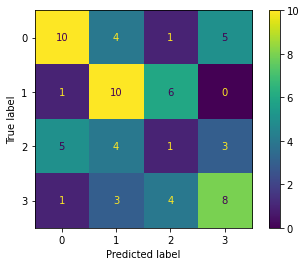

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
#multi-class classification Random Forest Doc2Vec 200
model_rf = RandomForestClassifier()

In [ ]:
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = model_rf.predict(X_test)

In [ ]:
y_pred

array(['Comedy', 'Comedy', 'Action', 'Comedy', 'Horror', 'Sci-Fi',
       'Horror', 'Sci-Fi', 'Action', 'Sci-Fi', 'Action', 'Comedy',
       'Action', 'Action', 'Action', 'Sci-Fi', 'Action', 'Action',
       'Horror', 'Sci-Fi', 'Horror', 'Action', 'Sci-Fi', 'Comedy',
       'Action', 'Action', 'Comedy', 'Comedy', 'Sci-Fi', 'Sci-Fi',
       'Sci-Fi', 'Action', 'Action', 'Action', 'Comedy', 'Action',
       'Action', 'Comedy', 'Action', 'Comedy', 'Comedy', 'Sci-Fi',
       'Action', 'Action', 'Sci-Fi', 'Action', 'Sci-Fi', 'Sci-Fi',
       'Comedy', 'Action', 'Action', 'Comedy', 'Comedy', 'Action',
       'Sci-Fi', 'Comedy', 'Action', 'Horror', 'Comedy', 'Sci-Fi',
       'Horror', 'Comedy', 'Horror', 'Sci-Fi', 'Sci-Fi', 'Action'],
      dtype=object)

In [ ]:
accuracy_score(y_test, y_pred)

0.3939393939393939

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Action       0.36      0.45      0.40        20
      Comedy       0.53      0.53      0.53        17
      Horror       0.14      0.08      0.10        13
      Sci-Fi       0.41      0.44      0.42        16

    accuracy                           0.39        66
   macro avg       0.36      0.37      0.36        66
weighted avg       0.37      0.39      0.38        66



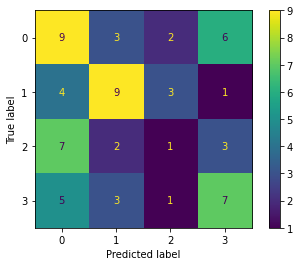

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()